# Unsupervised Learning: Trade&Ahead

**Marks: 60**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Security: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style='darkgrid')

# for scaling the data with Z-Score
from scipy.stats import zscore

# for distance computation
from scipy.spatial.distance import cdist, pdist

# to perform heirarchical clustering, compute cophenetic correlation and dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform k-means clustering and calculate/visualize silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



### Import the data
- view the head to ensure proper loading
- create a copy of the dataframe in a seperate cell to preserve the original data and provide a means to reload original date should the need arise.

In [2]:
# connect to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# to load the data into Colab
stock_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning/Stock Data Project/stock_data.csv')

In [4]:
# # to load the data into Jupyter
# stock_data = pd.read_csv('stock_data.csv')

In [5]:
stock_data.head()

Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
0                  6.681299e+08    3.718174  -8.784219  
1                  1.633016e+09   18.806350  -8.750068  
2                  1.504422e+09   15.275510  -0.394171  
3                  4.996437e+08   74.555557   4.199651  
4                  2.247994e+09  178.451613   1.059810

The data appears to have loaded properly.

Some values are in scientific notation, as very large numbers.  Will suppress scientific notation to two decimal places since they are large numbers, there is no need to go out many decimal places like I would for very small numbers.

In [6]:
# to suppress scientific notation for very large or very small numbers, will go to two places after the decimal
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
# create a copy to preserve the original data
df = stock_data.copy()

## Data Overview

- Observations
- Sanity checks


In [8]:
df.sample(10)

Ticker Symbol                   Security             GICS Sector  \
295          TSCO     Tractor Supply Company  Consumer Discretionary   
23           AMGN                  Amgen Inc             Health Care   
77            COO       The Cooper Companies             Health Care   
239          PBCT  People's United Financial              Financials   
178           KIM               Kimco Realty             Real Estate   
168            IP        International Paper               Materials   
97            DNB           Dun & Bradstreet             Industrials   
106           EFX               Equifax Inc.             Industrials   
279          SRCL             Stericycle Inc             Industrials   
145            GT     Goodyear Tire & Rubber  Consumer Discretionary   

                  GICS Sub Industry  Current Price  Price Change  Volatility  \
295                Specialty Retail          85.50          1.30        1.43   
23                    Biotechnology         162.33         17.16        1.63   
77             Health Care Supplies         134.20         -9.67        1.56   
239      Thrifts & Mortgage Finance          16.15          3.13        1.13   
178                           REITs          26.46          8.71        1.22   
168                 Paper Packaging          37.70         -0.03        1.30   
97   Research & Consulting Services         103.93         -1.19        1.34   
106  Research & Consulting Services         111.37         14.53        1.08   
279        Industrial Conglomerates         120.60        -13.91        1.20   
145                  Tires & Rubber          32.67         10.45        1.52   

     ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
295   29          10       12679000   410395000                3.03   
23    25         362      413000000  6939000000                9.15   
77     8           3       -8796000   203523000                1.79   
239    5          99     -298400000   260100000                0.86   
178   18          47        2212000   894115000                2.01   
168   24          27     -831000000   938000000                2.25   
97    15          38       46300000   168800000                4.68   
106   19          15      -35000000   429100000                3.61   
279   10           9       33398000   267046000                3.02   
145    8          30     -685000000   307000000                1.14   

     Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
295                  135443894.40      28.22       6.01  
23                   758360655.70      17.74      24.01  
77                   140335195.50      33.99       0.86  
239                  302441860.50      18.78      -0.43  
178                  444833333.30      13.16      -1.27  
168                  416888888.90      16.76       6.12  
97                    36068376.07      22.21     -11.88  
106                  118864265.90      30.85      -8.12  
279                   88425827.81      39.93     -18.86  
145                  269298245.60      28.66       3.84

In [9]:
# check the shape of the dataframe
df.shape

(340, 15)

There are 340 records with 15 features

In [10]:
# check the non-null count and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

All features have 340 non-null values.  The numeric columns are all int/float dtypes and the categorical string features are objects.

This all appears normal and set appropriately.

In [11]:
# check for nulls
df.isnull().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

There are no null values in any of the features.

In [12]:
# check for duplicate entries
df.duplicated().sum()

0

Threre are no duplicated rows.

In [13]:
# get a statistical summary of the data
df.describe(include='all').T

count unique  \
Ticker Symbol                   340    340   
Security                        340    340   
GICS Sector                     340     11   
GICS Sub Industry               340    104   
Current Price                340.00    NaN   
Price Change                 340.00    NaN   
Volatility                   340.00    NaN   
ROE                          340.00    NaN   
Cash Ratio                   340.00    NaN   
Net Cash Flow                340.00    NaN   
Net Income                   340.00    NaN   
Earnings Per Share           340.00    NaN   
Estimated Shares Outstanding 340.00    NaN   
P/E Ratio                    340.00    NaN   
P/B Ratio                    340.00    NaN   

                                                             top freq  \
Ticker Symbol                                                AAL    1   
Security                                 American Airlines Group    1   
GICS Sector                                          Industrials   53   
GICS Sub Industry             Oil & Gas Exploration & Production   16   
Current Price                                                NaN  NaN   
Price Change                                                 NaN  NaN   
Volatility                                                   NaN  NaN   
ROE                                                          NaN  NaN   
Cash Ratio                                                   NaN  NaN   
Net Cash Flow                                                NaN  NaN   
Net Income                                                   NaN  NaN   
Earnings Per Share                                           NaN  NaN   
Estimated Shares Outstanding                                 NaN  NaN   
P/E Ratio                                                    NaN  NaN   
P/B Ratio                                                    NaN  NaN   

                                      mean           std             min  \
Ticker Symbol                          NaN           NaN             NaN   
Security                               NaN           NaN             NaN   
GICS Sector                            NaN           NaN             NaN   
GICS Sub Industry                      NaN           NaN             NaN   
Current Price                        80.86         98.06            4.50   
Price Change                          4.08         12.01          -47.13   
Volatility                            1.53          0.59            0.73   
ROE                                  39.60         96.55            1.00   
Cash Ratio                           70.02         90.42            0.00   
Net Cash Flow                  55537620.59 1946365312.18 -11208000000.00   
Net Income                   1494384602.94 3940150279.33 -23528000000.00   
Earnings Per Share                    2.78          6.59          -61.20   
Estimated Shares Outstanding  577028337.75  845849595.42     27672156.86   
P/E Ratio                            32.61         44.35            2.94   
P/B Ratio                            -1.72         13.97          -76.12   

                                       25%          50%           75%  \
Ticker Symbol                          NaN          NaN           NaN   
Security                               NaN          NaN           NaN   
GICS Sector                            NaN          NaN           NaN   
GICS Sub Industry                      NaN          NaN           NaN   
Current Price                        38.55        59.70         92.88   
Price Change                         -0.94         4.82         10.70   
Volatility                            1.13         1.39          1.70   
ROE                                   9.75        15.00         27.00   
Cash Ratio                           18.00        47.00         99.00   
Net Cash Flow                -193906500.00   2098000.00  169810750.00   
Net Income                    352301250.00 707336000.00 1899000000.00   
Earnings Per Share             

There are 11 different GICS Sectors and 104 GICS Sub-Sectors.

Most numerical features appear to have normal values.
- I expect outliers, as the min and max for some values, such as Net Cash Flow, and Net Income have a min the negative billions and max in the positive billions.  
- Shares outstanding has numbers in the multiple billions as well, but these are normal numbers for some large companies.

I expect a right skew on most features based on 75th percentile and max.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

###Define functions to aid in visualization

In [14]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [15]:
# function to create labeled barplots


def labeled_barplot(df, feature, perc=False, n=None, title=None, rot=90, rotation_mode='anchor'):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    title: title for the barplot (default is None)
    rot: set xticks rotation (default is 90)
    rotation_mode: (default 'anchor')
    """

    total = len(df[feature])  # length of the column
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    plt.title(title, fontsize=20)
    plt.xticks(rotation=rot, fontsize=15, ha='right',rotation_mode =rotation_mode)
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="Paired",
        order=df[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

In [16]:
# list the numeric columns
num_cols = df.select_dtypes([np.number]).columns
num_cols

Index(['Current Price', 'Price Change', 'Volatility', 'ROE', 'Cash Ratio',
       'Net Cash Flow', 'Net Income', 'Earnings Per Share',
       'Estimated Shares Outstanding', 'P/E Ratio', 'P/B Ratio'],
      dtype='object')

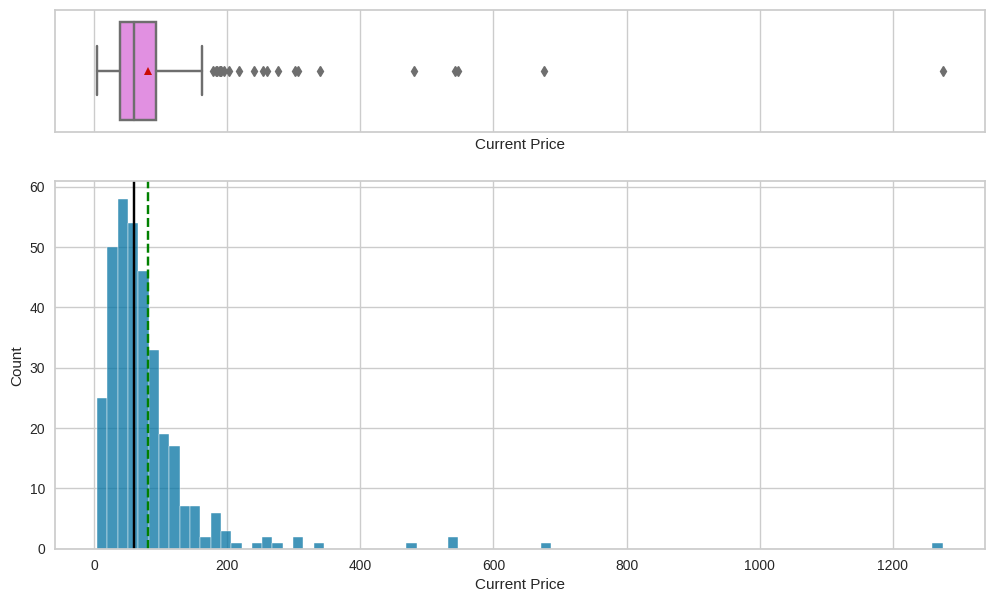

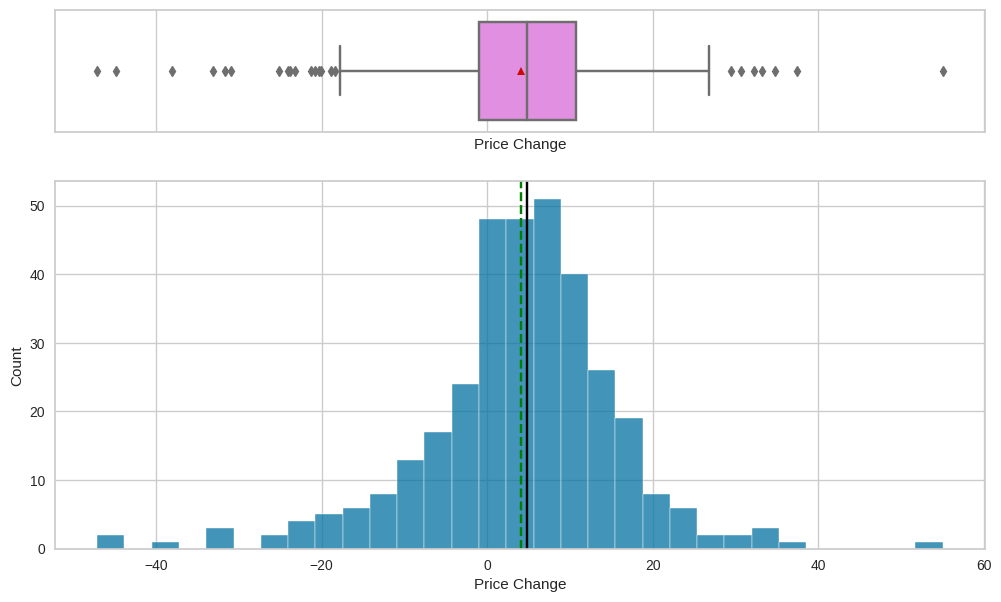

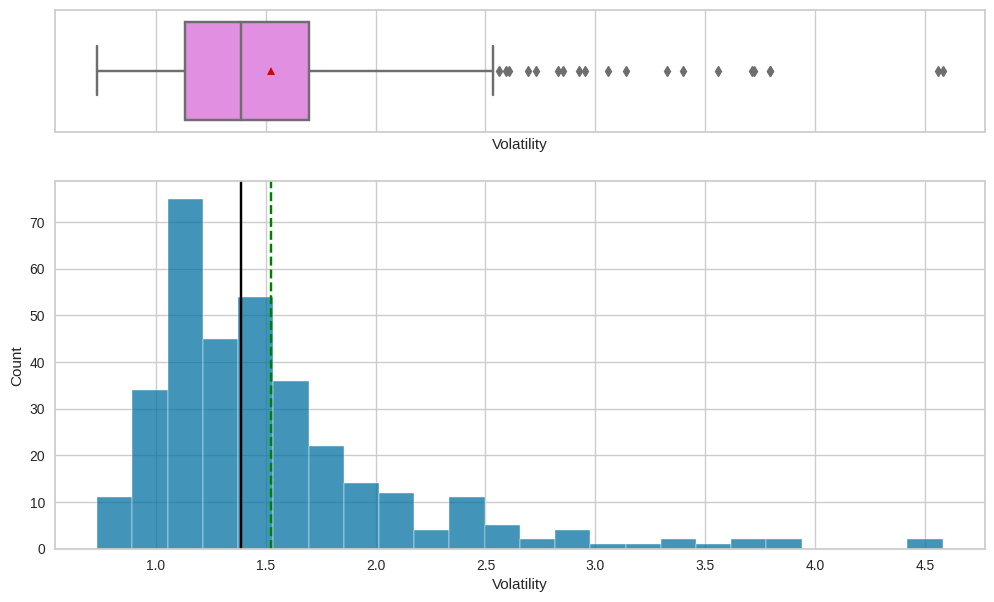

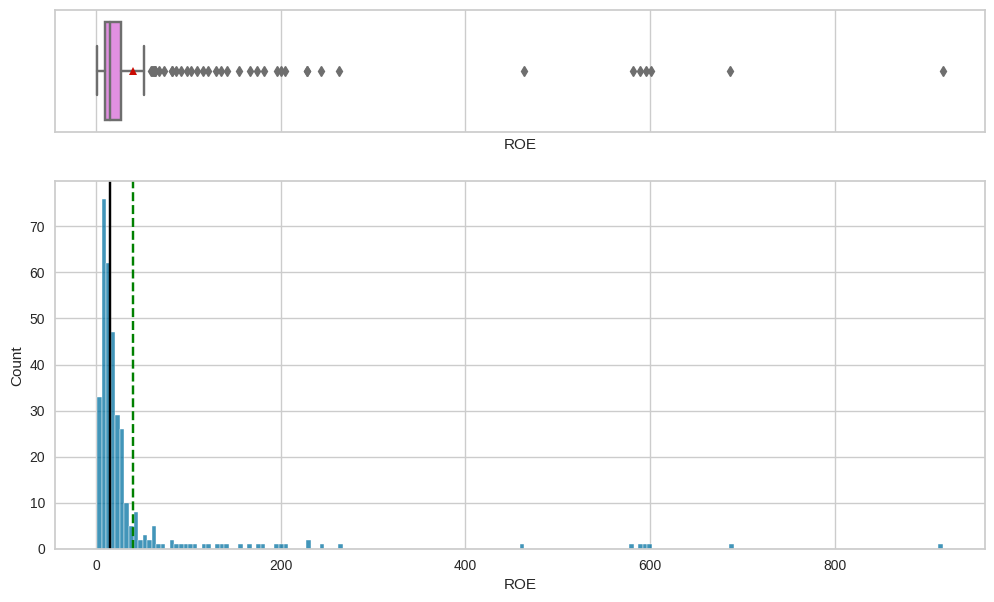

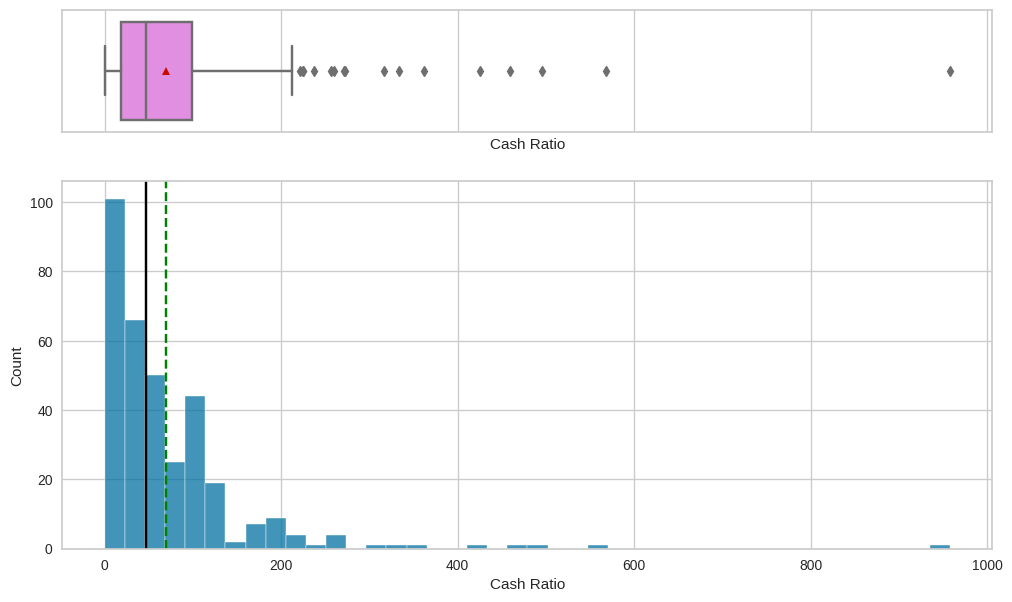

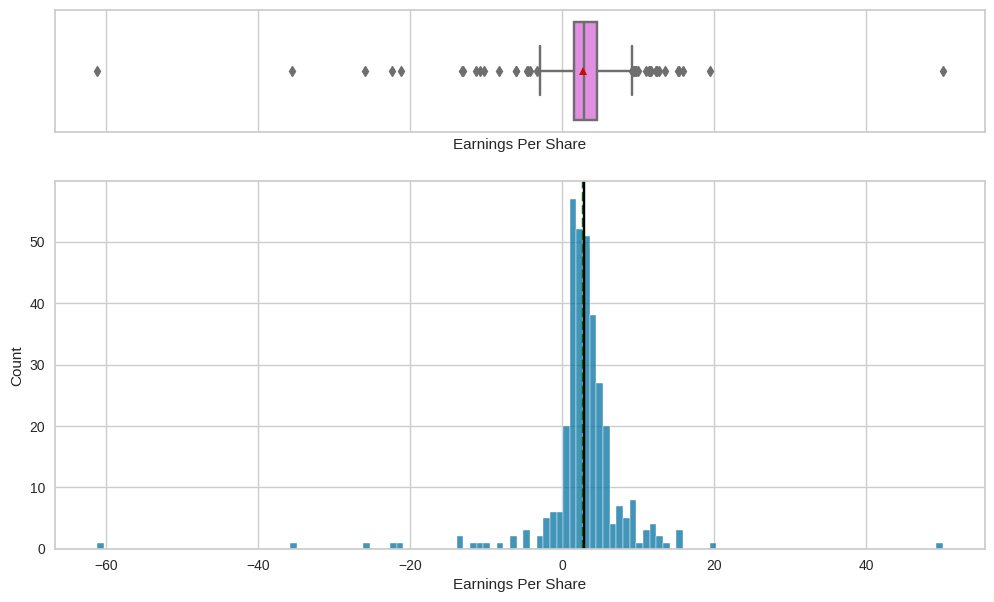

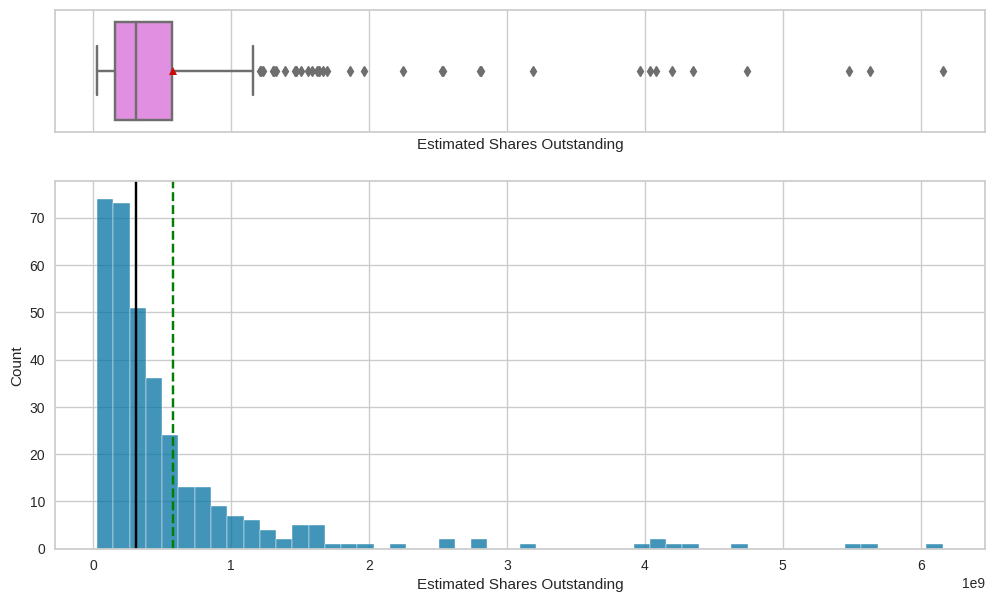

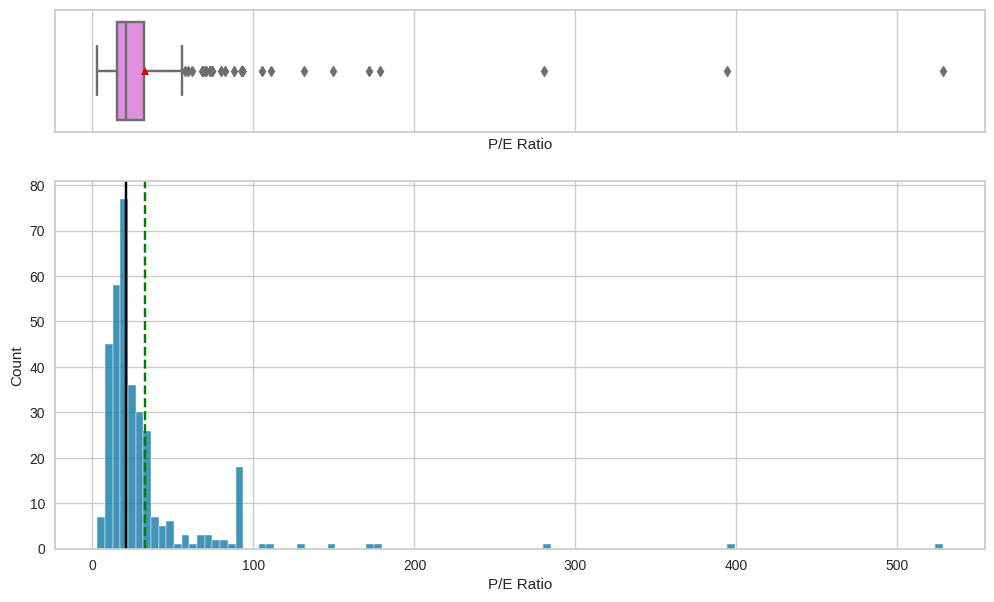

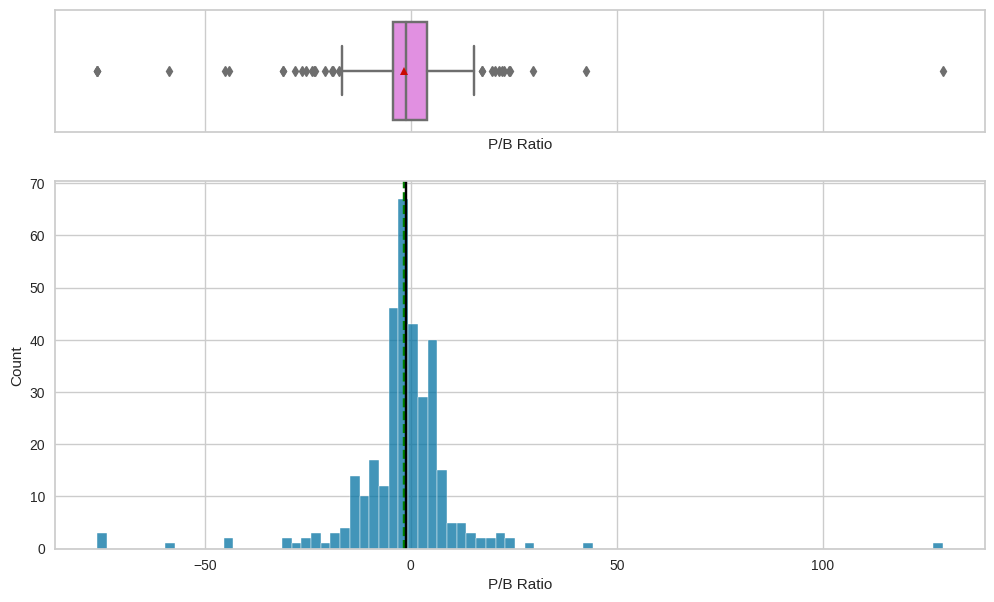

In [17]:
# plot a histogram_boxplot for each of the numerical features
for i, col in enumerate(num_cols):
  histogram_boxplot(df, col)

Price Change, Net Cash Flow, Net Income, Earnings Per Share, and P/B Ratio are normally distributed with a few outliers.

The rest of the features all have right skews with far-right outliers.

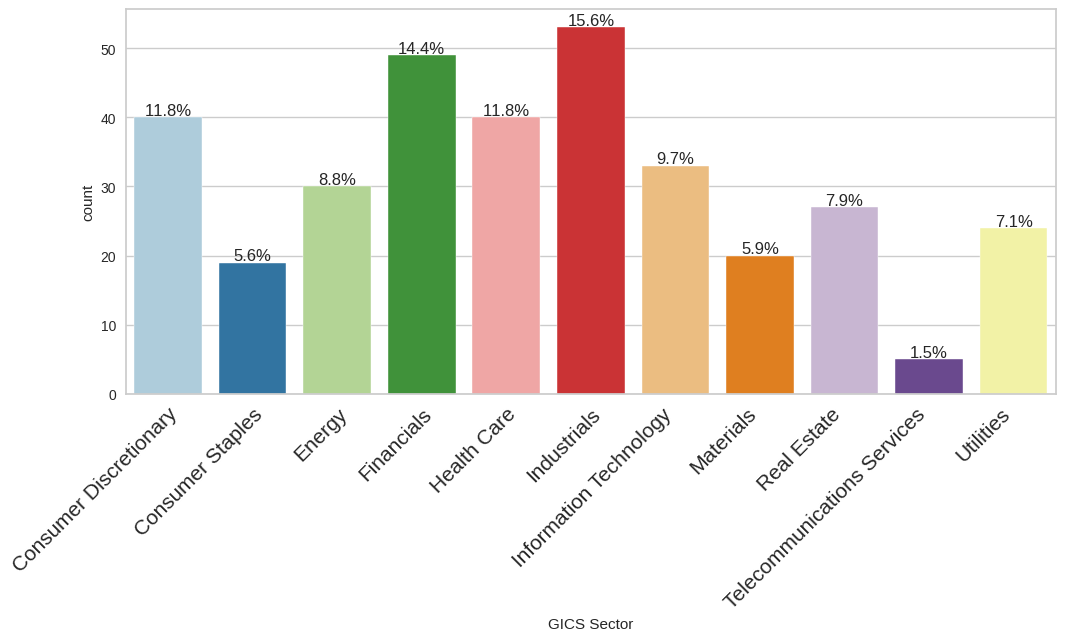

In [18]:
# plot the breakdown of each Sector accross all the data
labeled_barplot(df, 'GICS Sector', perc=True, rot=45)


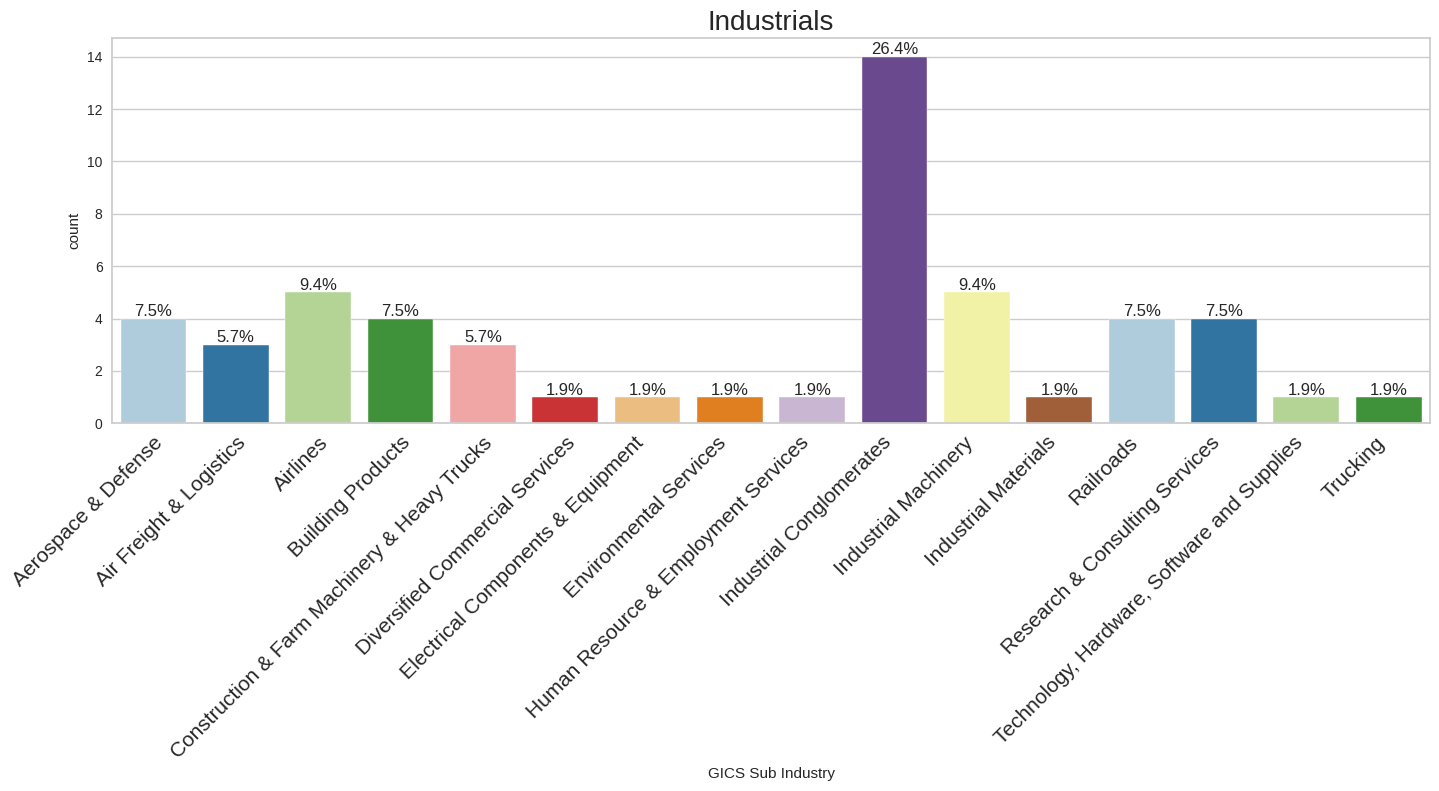

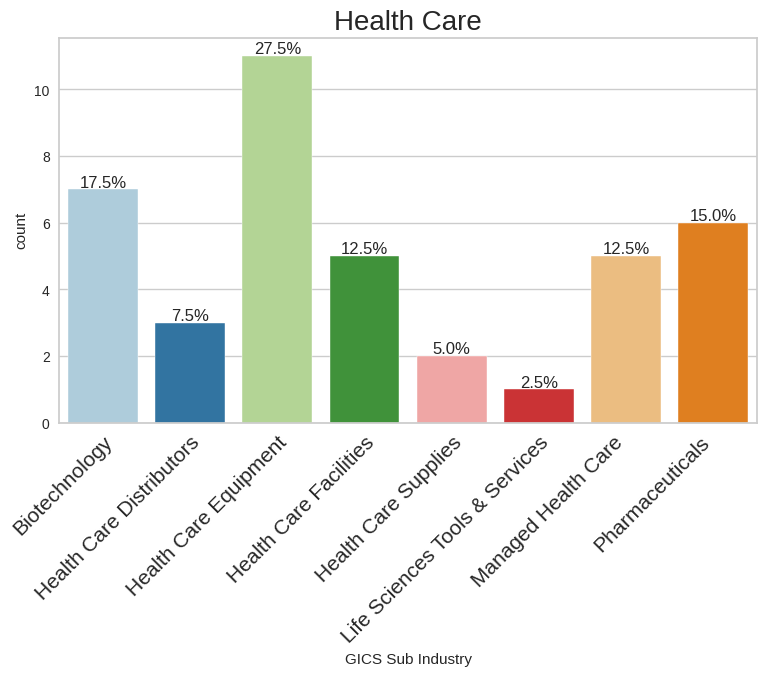

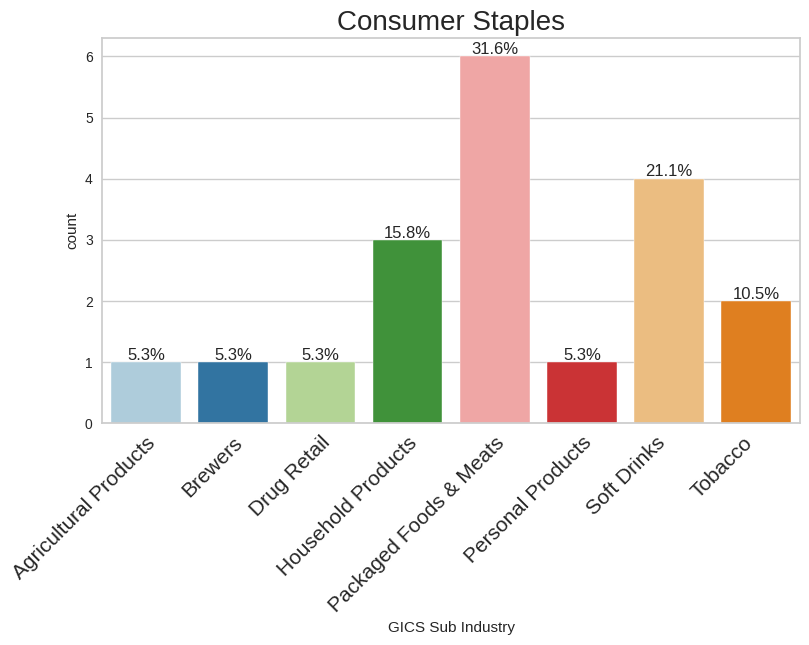

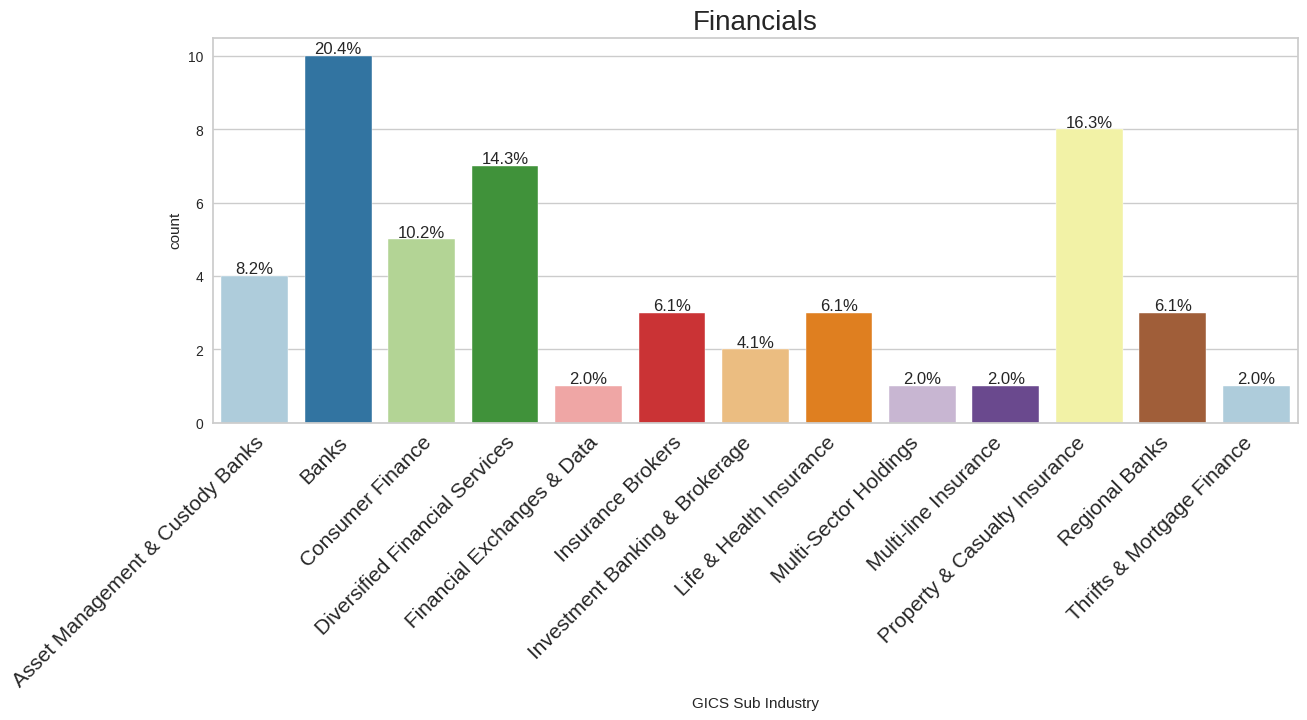

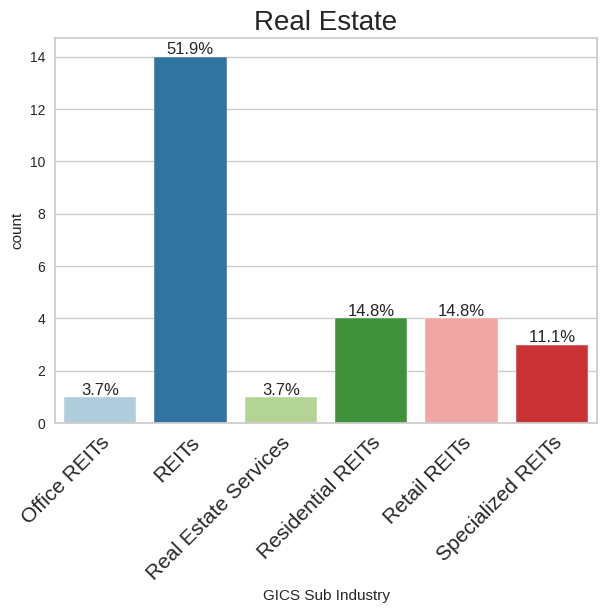

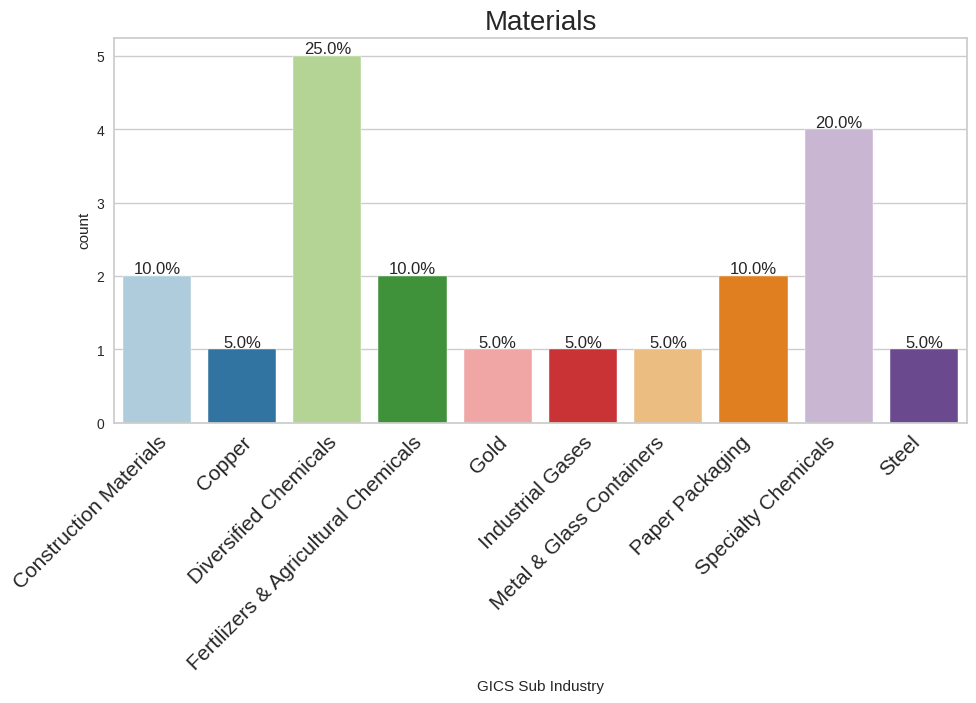

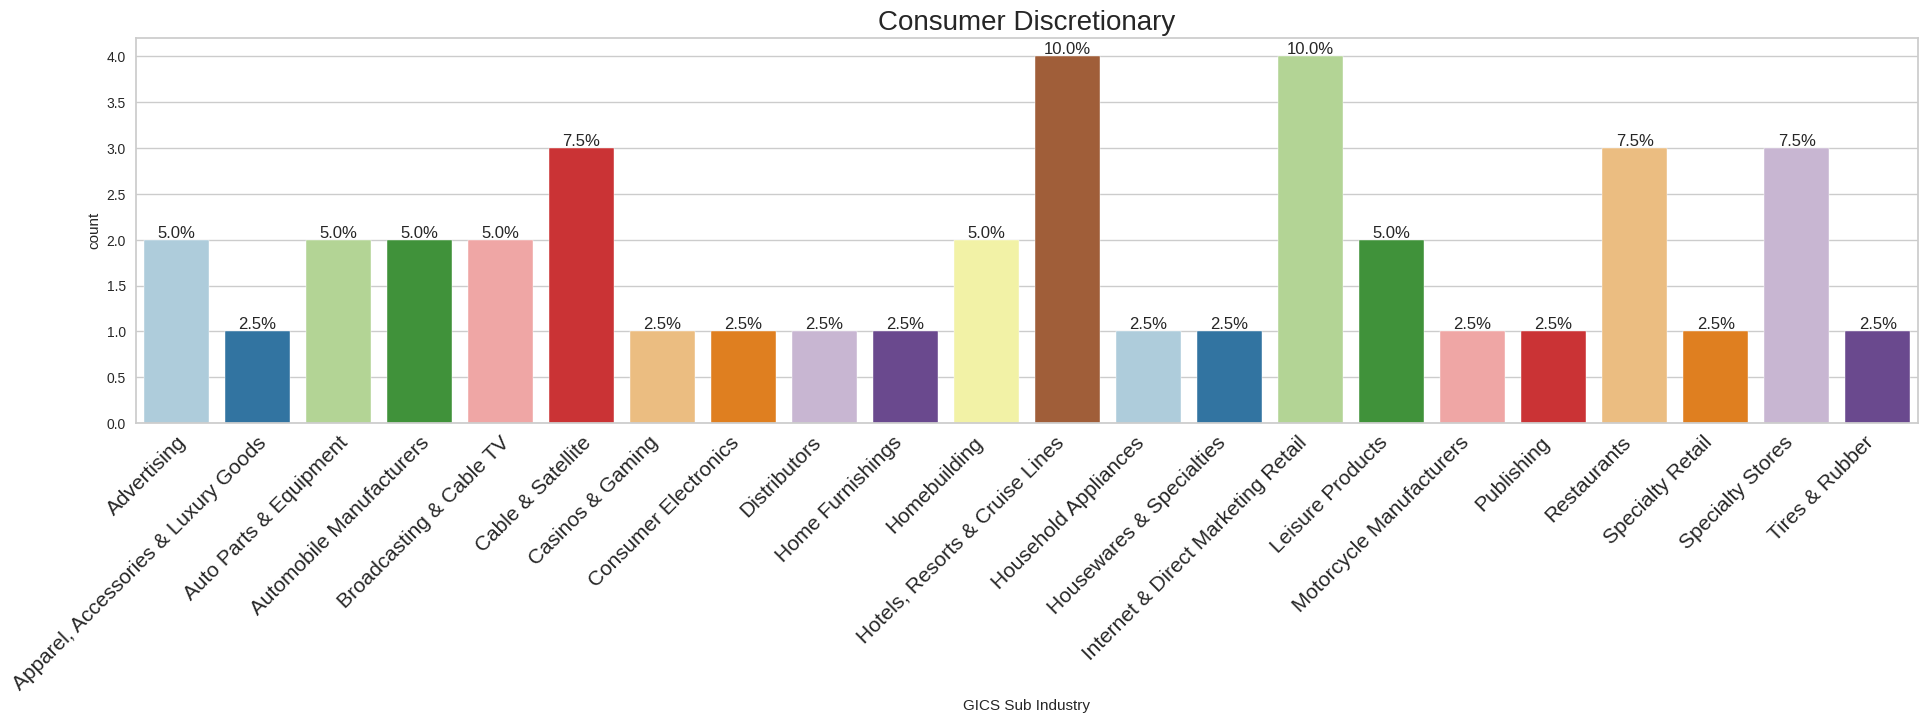

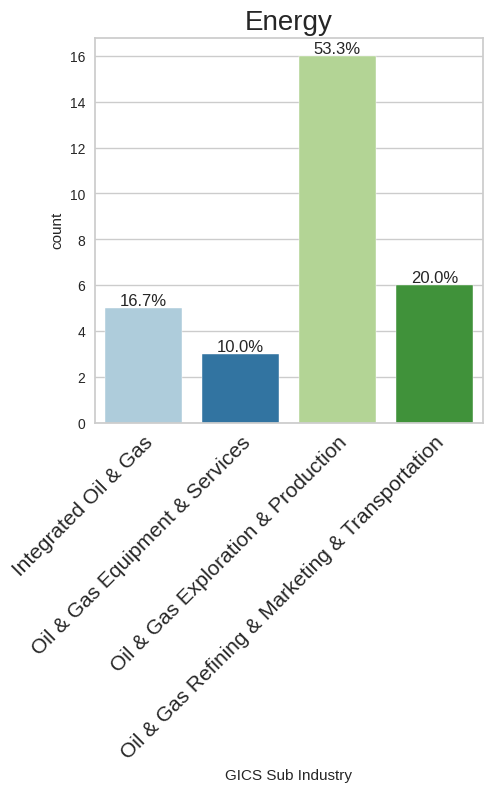

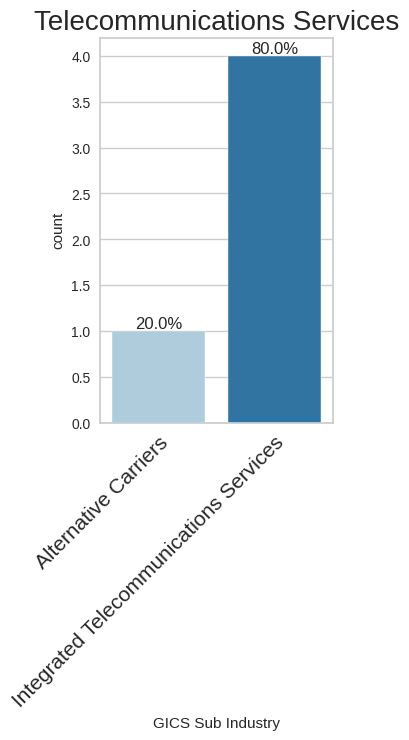

In [19]:
# let's see what the sub-industry breakdown is for each GICS Sector
for i in df['GICS Sector'].unique():
  labeled_barplot(df[df['GICS Sector']==i], 'GICS Sub Industry', perc=True, title=i, rot=45)
  

### Bivariate analysis

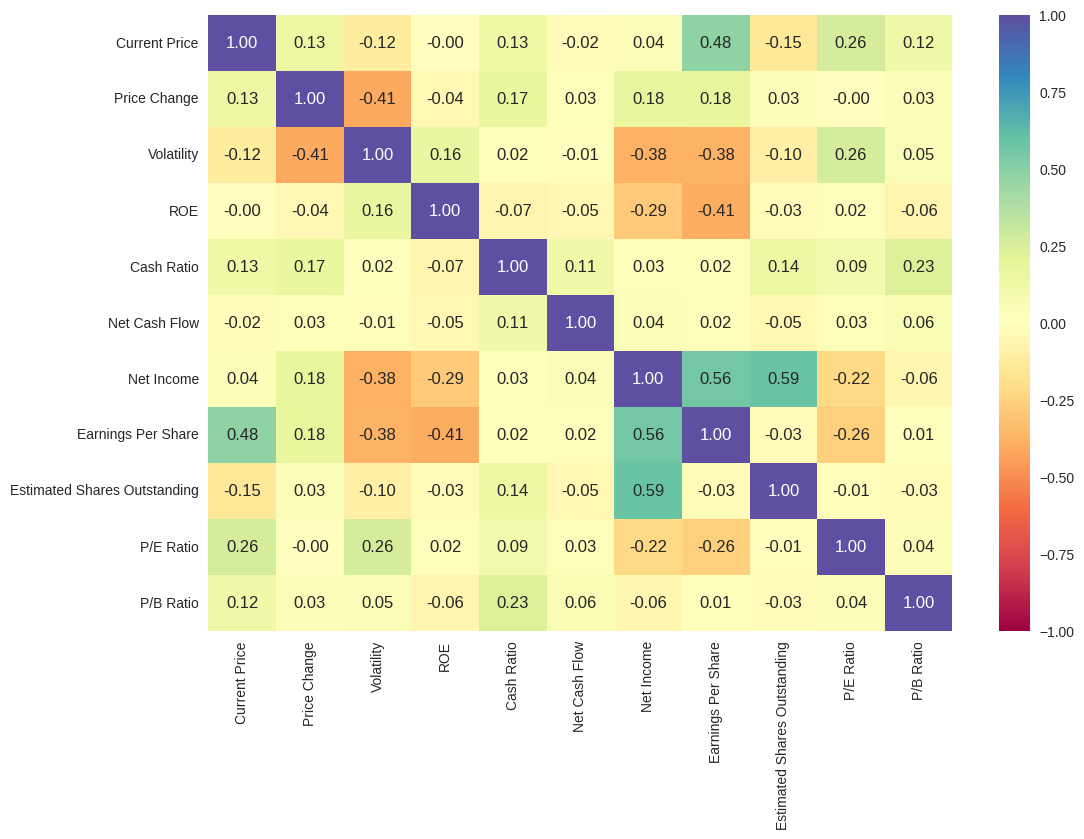

In [20]:
# Correlation check among numerical features
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='Spectral');

- There is a correlation between Net Income and Estimated Shares Outstanding which is a bit surprising.
- There is a decent correlation between Net Income and Earning Per Share, which makes sense.
- There is a slight negative correlaiton ROE and Earnings Per Share.
- There is a slight negative correlation between Volatility and Price Change, which makes sense.

### Stakeholder Specified EDA Questions

####**Question 1** What does the distribution of stock prices look like?

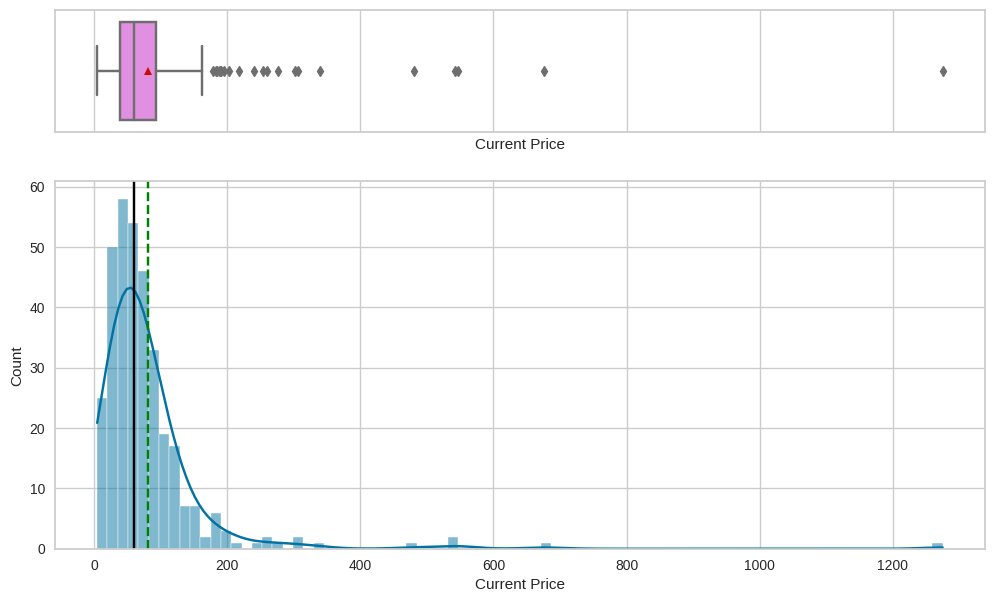

In [21]:
histogram_boxplot(df, 'Current Price', kde=True);

In [22]:
print(' Median:',df['Current Price'].median(),'\n',
      'Mean:', df['Current Price'].mean(),'\n',
      'Max:', df['Current Price'].max(),'\n',
      'Min:',df['Current Price'].min())

 Median: 59.705 
 Mean: 80.86234477216765 
 Max: 1274.949951 
 Min: 4.5


The current stock price has a long right skew with some far-right outliers.  This skew can be seen in the offset of the Mean to the right of the Median. 

50% of the stock prices are currently below 60 per share, with a mean of about 80 and a max of over 1270

The majority of stock prices are normally distributed between 4 dollars and 200 dollars.

####**Question 2** 
The stocks of which economic sector have seen the maximum price increase on average?

In [23]:
# plot the Price Change (mean accross the Sector as a percentage) for each GICS Sector
sns.lineplot(df.groupby(['GICS Sector'])['Price Change'].mean());
plt.xticks(rotation=90)
plt.show()



The **Health Care** and **Consumer Staples** sectors have seen the largest **increase** in stock price. 

Note: The Energy Sector has seen a large decrease in average stock price.

#### **Question 3**
How are the different variables correlated with each other?

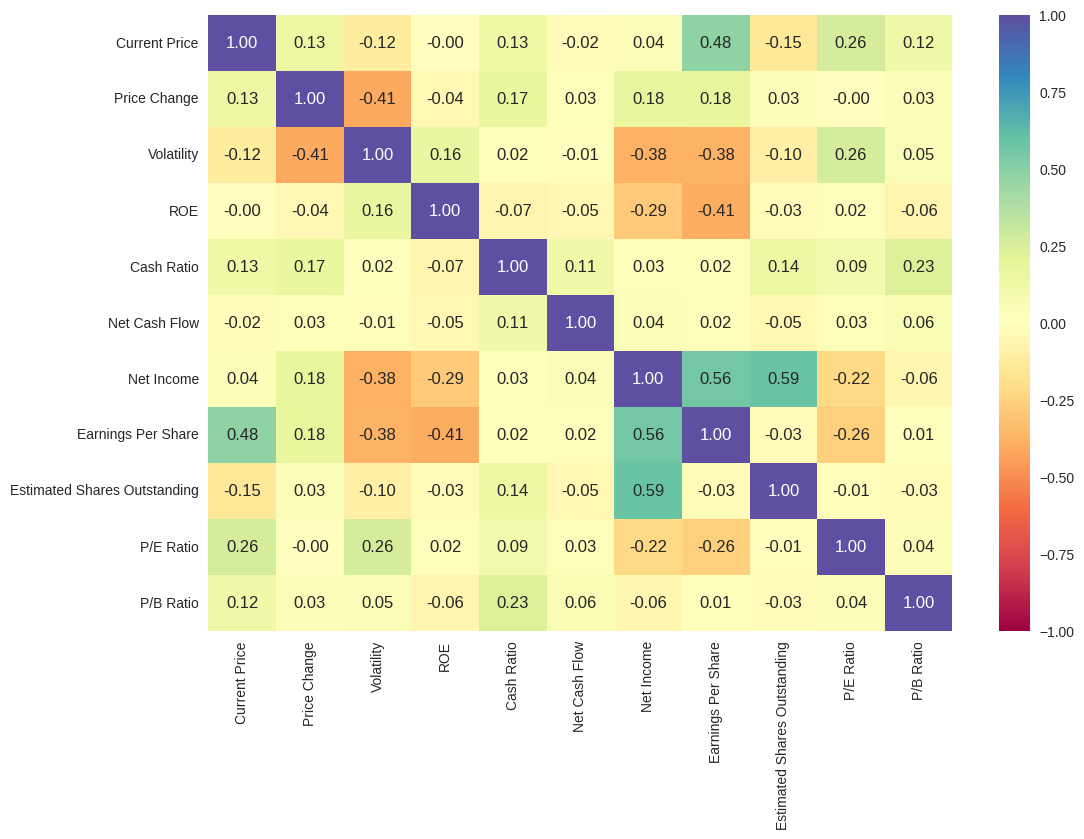

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True,  fmt= '.2f', vmin=-1, vmax=1, cmap='Spectral');

- There is a correlation between Net Income and Estimated Shares Outstanding which is a bit surprising.
- There is a decent correlation between Net Income and Earning Per Share, which makes sense.
- There is a slight negative correlaiton ROE and Earnings Per Share.
- There is a slight negative correlation between Volatility and Price Change, which makes sense.

#### **Question 4**
Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

In [25]:
sns.lineplot(df.groupby(['GICS Sector'])['Cash Ratio'].mean());
plt.xticks(rotation=90)
plt.show()

IT and Telecom have the highest Cash Ratios, with Utilities and Industrials having the lowest Cash Ratios.

#### **Question 5**
P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

In [26]:
sns.lineplot(df.groupby(['GICS Sector'])['P/E Ratio'].mean());
plt.xticks(rotation=90)
plt.show()

**Energy** has the **highest P/E** ratio, with Health Care, IT, and Real Estate having similar P/E ratios. 

Telecom and Financials have the lowest P/E ratios.

## Data Preprocessing

- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

In [28]:
# drop the uneccesary columns 'Ticker Symbol' and 'Security'
df1= df.drop(['Ticker Symbol', 'Security'], axis=1)

In [29]:
# convert GICS Sector and GICS Sub Industry to numerical values using dummy variables (one-hot with drop_first=True)
df1 = pd.get_dummies(df1, drop_first=True)
df1.head()

Current Price  Price Change  Volatility  ROE  Cash Ratio  Net Cash Flow  \
0          42.35         10.00        1.69  135          51     -604000000   
1          59.24          8.34        2.20  130          77       51000000   
2          44.91         11.30        1.27   21          67      938000000   
3          93.94         13.98        1.36    9         180     -240840000   
4          55.32         -1.83        1.70   14         272      315120000   

   Net Income  Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  \
0  7610000000               11.39                  668129938.50       3.72   
1  5144000000                3.15                 1633015873.00      18.81   
2  4423000000                2.94                 1504421769.00      15.28   
3   629551000                1.26                  499643650.80      74.56   
4   696878000                0.31                 2247993548.00     178.45   

   ...  GICS Sub Industry_Specialty Retail  \
0  ...                                   0   
1  ...                                   0   
2  ...                                   0   
3  ...                                   0   
4  ...                                   0   

   GICS Sub Industry_Specialty Stores  GICS Sub Industry_Steel  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   0                        0   

   GICS Sub Industry_Technology Hardware, Storage & Peripherals  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0              

   GICS Sub Industry_Technology, Hardware, Software and Supplies  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   GICS Sub Industry_Thrifts & Mortgage Finance  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   GICS Sub Industry_Tires & Rubber  GICS Sub Industry_Tobacco  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   

   GICS Sub Industry_Trucking  GICS Sub Industry_Water Utilities  
0                           0                                  0  
1                           0                                  0  
2                           0                                  0  
3                           0                                  0  
4                           0                                  0  

[5 rows x 124 columns]

There are now 124 columns.  Will attempt K-Means clustering and then will work towards dimentionality reduction.

In [30]:
# Scale the data to each value's z-score
df1_scaled = df1.apply(zscore)

In [31]:
df1_scaled.head()

Current Price  Price Change  Volatility   ROE  Cash Ratio  Net Cash Flow  \
0          -0.39          0.49        0.27  0.99       -0.21          -0.34   
1          -0.22          0.36        1.14  0.94        0.08          -0.00   
2          -0.37          0.60       -0.43 -0.19       -0.03           0.45   
3           0.13          0.83       -0.28 -0.32        1.22          -0.15   
4          -0.26         -0.49        0.30 -0.27        2.24           0.13   

   Net Income  Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  \
0        1.55                1.31                          0.11      -0.65   
1        0.93                0.06                          1.25      -0.31   
2        0.74                0.02                          1.10      -0.39   
3       -0.22               -0.23                         -0.09       0.95   
4       -0.20               -0.37                          1.98       3.29   

   ...  GICS Sub Industry_Specialty Retail  \
0  ...                               -0.05   
1  ...                               -0.05   
2  ...                               -0.05   
3  ...                               -0.05   
4  ...                               -0.05   

   GICS Sub Industry_Specialty Stores  GICS Sub Industry_Steel  \
0                               -0.09                    -0.05   
1                               -0.09                    -0.05   
2                               -0.09                    -0.05   
3                               -0.09                    -0.05   
4                               -0.09                    -0.05   

   GICS Sub Industry_Technology Hardware, Storage & Peripherals  \
0                                              -0.05              
1                                              -0.05              
2                                              -0.05              
3                                              -0.05              
4                                              -0.05              

   GICS Sub Industry_Technology, Hardware, Software and Supplies  \
0                                              -0.05               
1                                              -0.05               
2                                              -0.05               
3                                              -0.05               
4                                              -0.05               

   GICS Sub Industry_Thrifts & Mortgage Finance  \
0                                         -0.05   
1                                         -0.05   
2                                         -0.05   
3                                         -0.05   
4                                         -0.05   

   GICS Sub Industry_Tires & Rubber  GICS Sub Industry_Tobacco  \
0                             -0.05                      -0.08   
1                             -0.05                      -0.08   
2                             -0.05                      -0.08   
3                             -0.05                      -0.08   
4                             -0.05                      -0.08   

   GICS Sub Industry_Trucking  GICS Sub Industry_Water Utilities  
0                       -0.05                              -0.05  
1                       -0.05                              -0.05  
2                       -0.05                              -0.05  
3                       -0.05                              -0.05  
4                       -0.05                              -0.05  

[5 rows x 124 columns]

All features are now on the same scale, having means of 0 and std devs of 1

## EDA

- It is a good idea to explore the data once again after manipulating it.

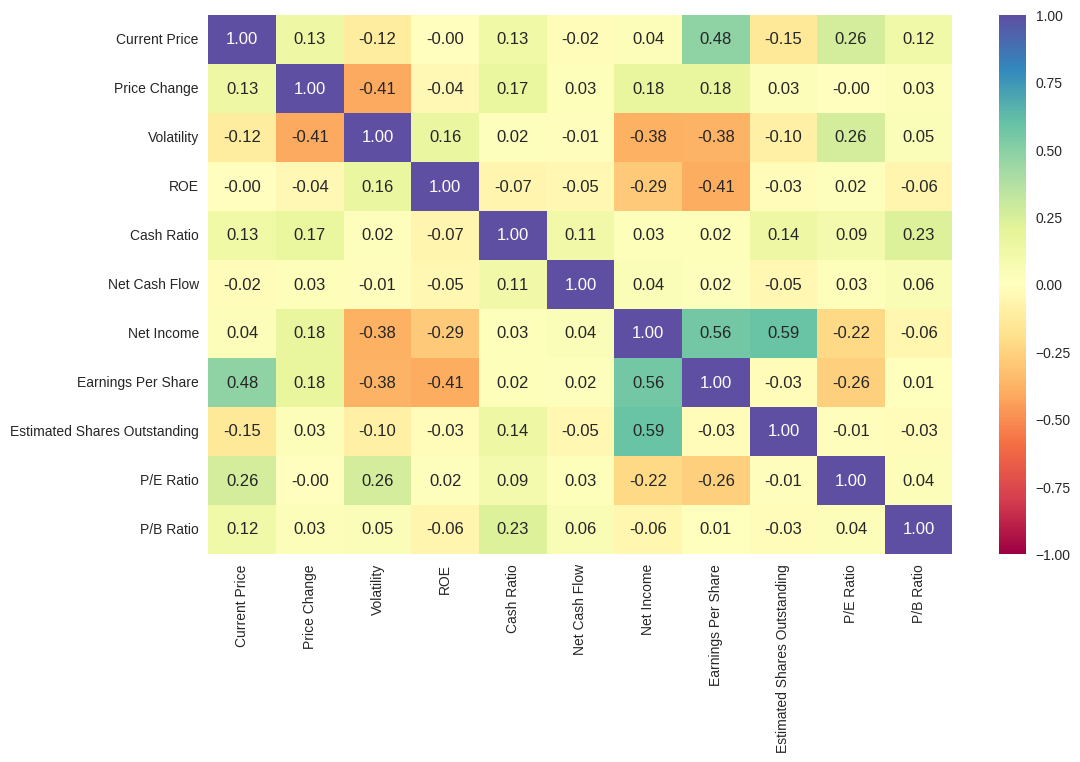

In [32]:
# Recheck correlation after scaling, will use num_cols so as to not have the dummy variables considered
plt.figure(figsize=(12,7))
sns.heatmap(df1_scaled[num_cols].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='Spectral');

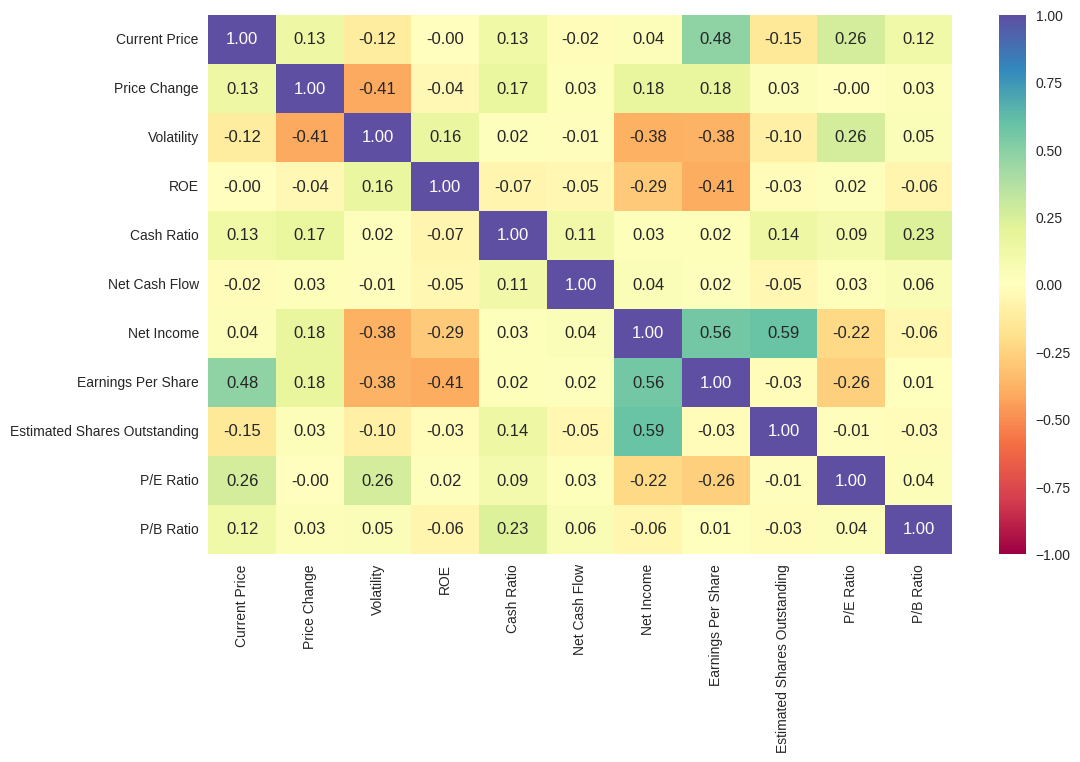

In [33]:
# check correlation of unscaled df for comparison
plt.figure(figsize=(12,7))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='Spectral');

Correlations remained the same between scaled and unscaled data, as expected.

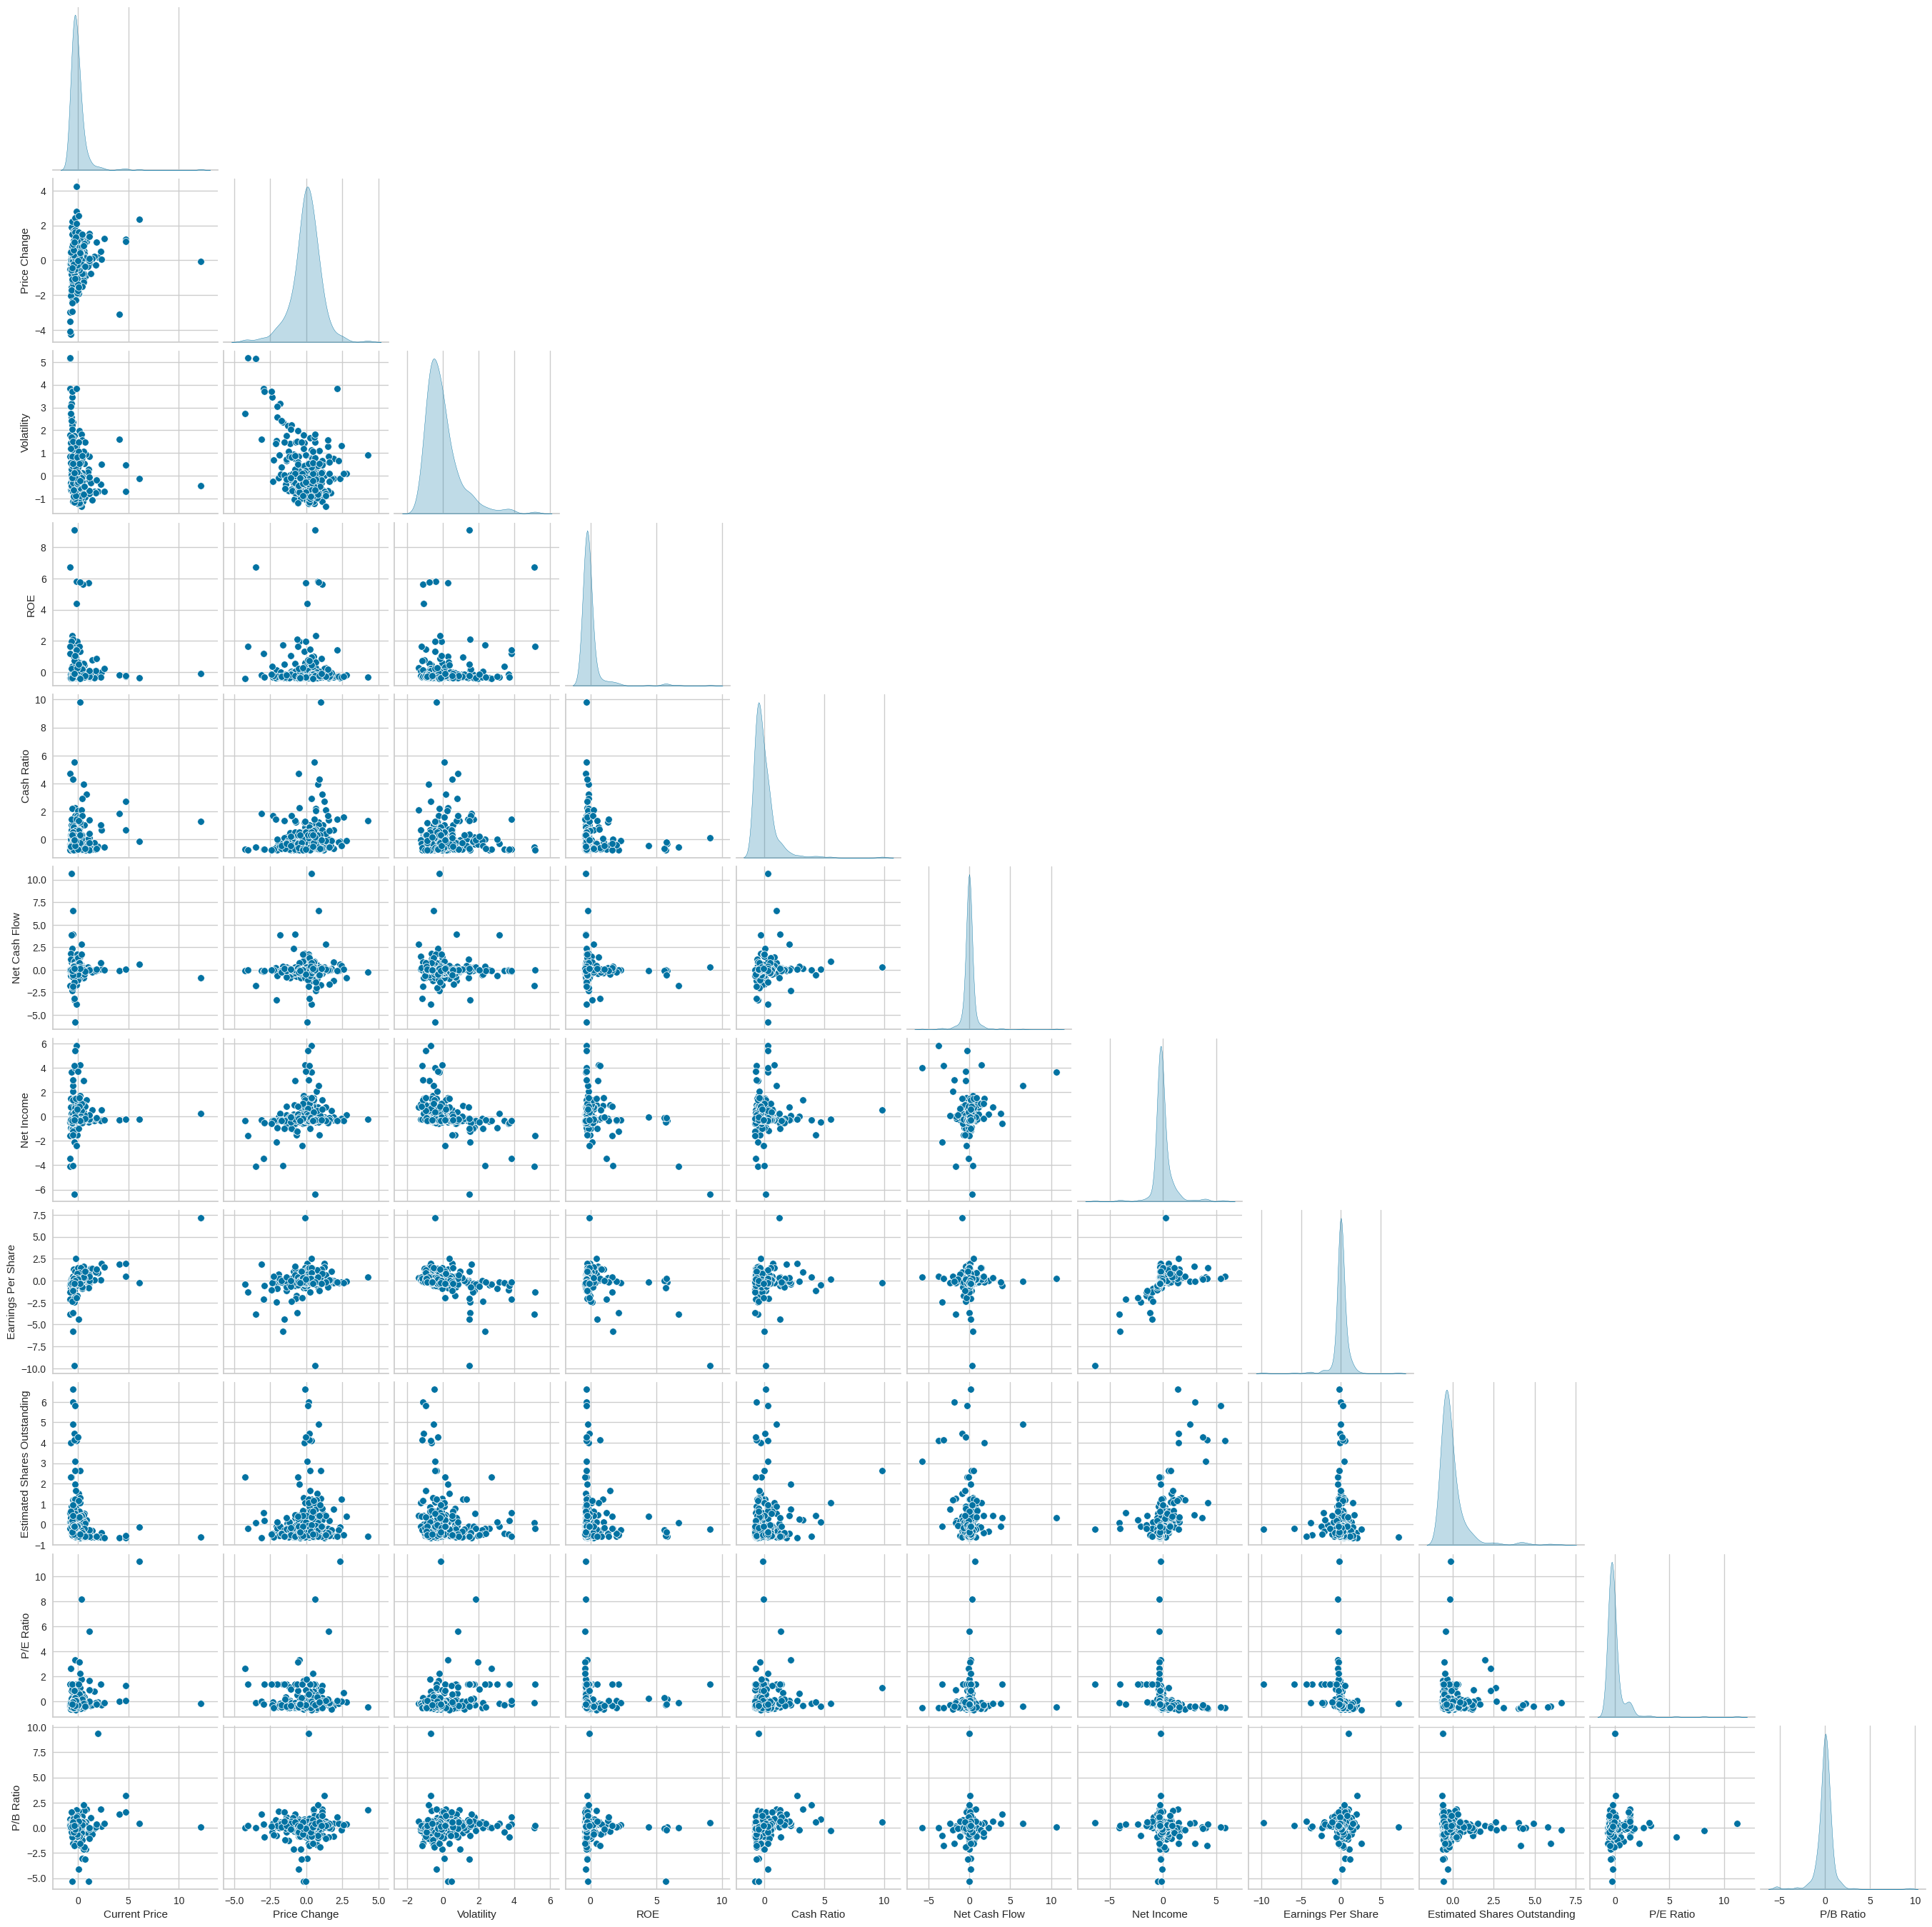

In [34]:
sns.pairplot(df1_scaled[num_cols], diag_kind='kde', corner=True)

## K-means Clustering

Use K-Means clustering to group data based on attributes. First, need to determint the optimal number of groups (k).

Will plot and look for an elbow.

In [35]:
# Import cdist for distance evaluation
from scipy.spatial.distance import cdist
# find the optimal (starting point) number of clusters 
clusters = range(1,10)
meanDistortions = []

for k in clusters:
  model = KMeans(n_clusters=k, n_init='auto')
  model.fit(df1_scaled)
  prediction = model.predict(df1_scaled)
  # find the lowest mean centroid points
  meanDistortions.append(sum(np.min(cdist(df1_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df1_scaled.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

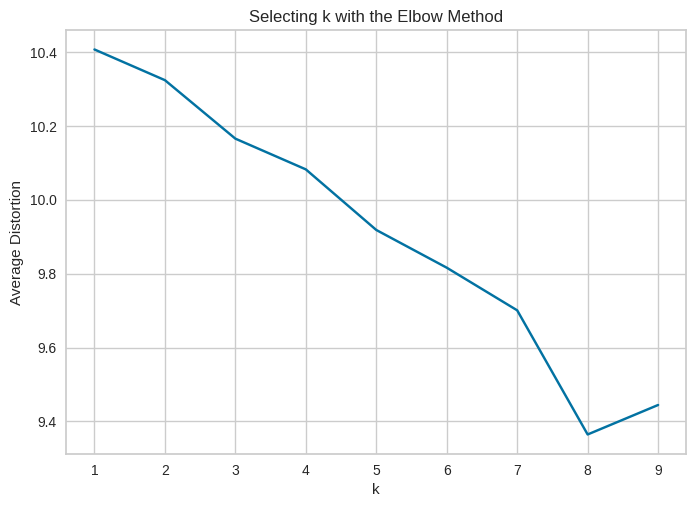

In [36]:
# plot the average distortion values of k
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method')

I ran the meanDistortions and plotting numerous times with a different plot each time.  Most of the iterations had an elbow at 4, 5, and/or 6.

Will k = 4, 5, and 6.  I expect 5 to be the final model, but will compare.

In [37]:
# create a copy to preserve the scaled df for future methods
df_kMeans= df1_scaled.copy()

In [38]:
# k=4
model_K4 = KMeans(4, n_init='auto')
model_K4.fit(df_kMeans)
prediction = model_K4.predict(df_kMeans)

# append the prediction, add GroupK2 column to the original df and scaled df
df['Group_K4']=prediction
df_kMeans['Group_K4']=prediction
print('Groups Assigned, k=4:\n')
df.head()

Groups Assigned, k=4:



Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines          42.35         10.00        1.69  135   
1        Pharmaceuticals          59.24          8.34        2.20  130   
2  Health Care Equipment          44.91         11.30        1.27   21   
3   Application Software          93.94         13.98        1.36    9   
4         Semiconductors          55.32         -1.83        1.70   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K4  
0                  668129938.50       3.72      -8.78         3  
1                 1633015873.00      18.81      -8.75         1  
2                 1504421769.00      15.28      -0.39         2  
3                  499643650.80      74.56       4.20         2  
4                 2247993548.00     178.45       1.06         0

In [39]:
# k=5
model_K5 = KMeans(5, n_init='auto')
model_K5.fit(df_kMeans[df_kMeans.columns[:-1]])
# Will not include the newly added Group_K2 column so as to not affect the clustering
prediction = model_K5.predict(df_kMeans[df_kMeans.columns[:-1]])

# append the prediction, add GroupK4 column to the original df and scaled df
df['Group_K5']=prediction
df_kMeans['Group_K5']=prediction
print('Groups Assigned, k=5:\n')
df.head()

Groups Assigned, k=5:



Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines          42.35         10.00        1.69  135   
1        Pharmaceuticals          59.24          8.34        2.20  130   
2  Health Care Equipment          44.91         11.30        1.27   21   
3   Application Software          93.94         13.98        1.36    9   
4         Semiconductors          55.32         -1.83        1.70   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K4  Group_K5  
0                  668129938.50       3.72      -8.78         3         1  
1                 1633015873.00      18.81      -8.75         1         1  
2                 1504421769.00      15.28      -0.39         2         1  
3                  499643650.80      74.56       4.20         2         2  
4                 2247993548.00     178.45       1.06         0         2

In [40]:
# k=6
model_K6 = KMeans(6, n_init=10)
model_K6.fit(df_kMeans[df_kMeans.columns[:-2]])
# will not include the k2 and k4 columns previously added
prediction = model_K6.predict(df_kMeans[df_kMeans.columns[:-2]])

# append the prediction, add GroupK6 column to the original df and scaled df
df['Group_K6']=prediction
df_kMeans['Group_K6']=prediction
print('Groups Assigned, k=6:\n')
df.head()

Groups Assigned, k=6:



Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines          42.35         10.00        1.69  135   
1        Pharmaceuticals          59.24          8.34        2.20  130   
2  Health Care Equipment          44.91         11.30        1.27   21   
3   Application Software          93.94         13.98        1.36    9   
4         Semiconductors          55.32         -1.83        1.70   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K4  Group_K5  \
0                  668129938.50       3.72      -8.78         3         1   
1                 1633015873.00      18.81      -8.75         1         1   
2                 1504421769.00      15.28      -0.39         2         1   
3                  499643650.80      74.56       4.20         2         2   
4                 2247993548.00     178.45       1.06         0         2   

   Group_K6  
0         0  
1         0  
2         0  
3         0  
4         0

Compare the different k-clusters (k=4, 5, 6)

In [41]:
# view the original df average values with k=4 clusters
print('K=4')
stock_data_cluster_4 = df.groupby(['Group_K4'])
stock_data_cluster_4.mean(numeric_only = True)

K=4


Current Price  Price Change  Volatility   ROE  Cash Ratio  \
Group_K4                                                              
0                 72.09         14.44        1.69 21.17      189.67   
1                 46.87          7.45        1.40 28.36       90.71   
2                102.08          0.83        1.91 44.25      103.06   
3                 71.68          5.35        1.32 38.32       46.85   

          Net Cash Flow    Net Income  Earnings Per Share  \
Group_K4                                                    
0         2160615333.33 2968599833.33                3.01   
1        -1964764285.71 8855428571.43                2.55   
2           56395368.42  361177307.02                1.10   
3          131052072.82 1578295888.35                3.71   

          Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K5  \
Group_K4                                                                 
0                        1560855047.20      43.43       6.95      1.67   
1                        2985309773.09      24.02      -5.62      1.00   
2                         512041814.10      52.89       3.00      1.64   
3                         420666994.77      21.66      -4.31      1.60   

          Group_K6  
Group_K4            
0             0.00  
1             0.29  
2             0.35  
3             0.64

In [42]:
# view the original df average values with k=5 clusters
print('K=5')
stock_data_cluster_5 = df.groupby(['Group_K5'])
stock_data_cluster_5.mean(numeric_only = True)

K=5


Current Price  Price Change  Volatility   ROE  Cash Ratio  \
Group_K5                                                              
0                 62.87          3.11        1.06 19.33       99.00   
1                 91.11          9.12        1.42 43.99       97.76   
2                 74.56          0.60        1.61 37.42       49.17   
3                 55.09          1.85        1.07 11.67       99.00   
4                 34.20        -10.24        2.60 13.00       43.50   

          Net Cash Flow    Net Income  Earnings Per Share  \
Group_K5                                                    
0         -136000000.00 1113600000.00                3.34   
1          226552878.57 2921669364.29                4.49   
2          -58588937.50  446254447.92                1.48   
3          543788000.00 2790033333.33                4.90   
4        -1404450000.00  832650000.00                2.88   

          Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K4  \
Group_K5                                                                 
0                         328176482.87      18.97      -6.52      3.00   
1                         815577331.43      26.15      -2.00      2.44   
2                         410072982.26      38.09      -1.48      2.59   
3                         569276010.37      11.41      -1.88      3.00   
4                         291219181.05      11.81       2.73      2.00   

          Group_K6  
Group_K5            
0             0.00  
1             0.37  
2             0.64  
3             0.00  
4             0.00

In [43]:
# view the original df average values with k=6 clusters
print('K=6')
stock_data_cluster_6 = df.groupby(['Group_K6'])
stock_data_cluster_6.mean(numeric_only = True)

K=6


Current Price  Price Change  Volatility    ROE  Cash Ratio  \
Group_K6                                                               
0                 88.29          5.91        1.45  30.50       77.14   
1                 36.95        -14.94        2.88 118.88       57.04   
2                 58.10         -2.37        2.00  15.50       27.50   
3                 52.97          0.80        1.12   9.88       13.62   
4                 70.28         10.36        1.16 109.15       82.23   
5                 78.33          3.07        1.73 209.00       16.67   

          Net Cash Flow     Net Income  Earnings Per Share  \
Group_K6                                                     
0           35408922.22  2018954903.70                3.95   
1          122018875.00 -4421492666.67              -10.71   
2         -370166666.67  2176333333.33                5.66   
3          176462291.67  1107145541.67                2.75   
4          333218000.00  2127867076.92                3.18   
5           16000000.00   599000000.00               -2.43   

          Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K4  \
Group_K6                                                                 
0                         592054023.11      29.85      -1.15      2.53   
1                         438539760.13      79.54       2.20      2.00   
2                         818376449.87      44.89       4.70      2.00   
3                         380919306.56      18.72      -3.09      3.00   
4                         878708030.41      25.96      -3.95      2.77   
5                         111522633.70      20.82     -76.12      3.00   

          Group_K5  
Group_K6            
0             1.53  
1             2.00  
2             2.00  
3             2.00  
4             1.00  
5             2.00

Visualize the 3 different values for k

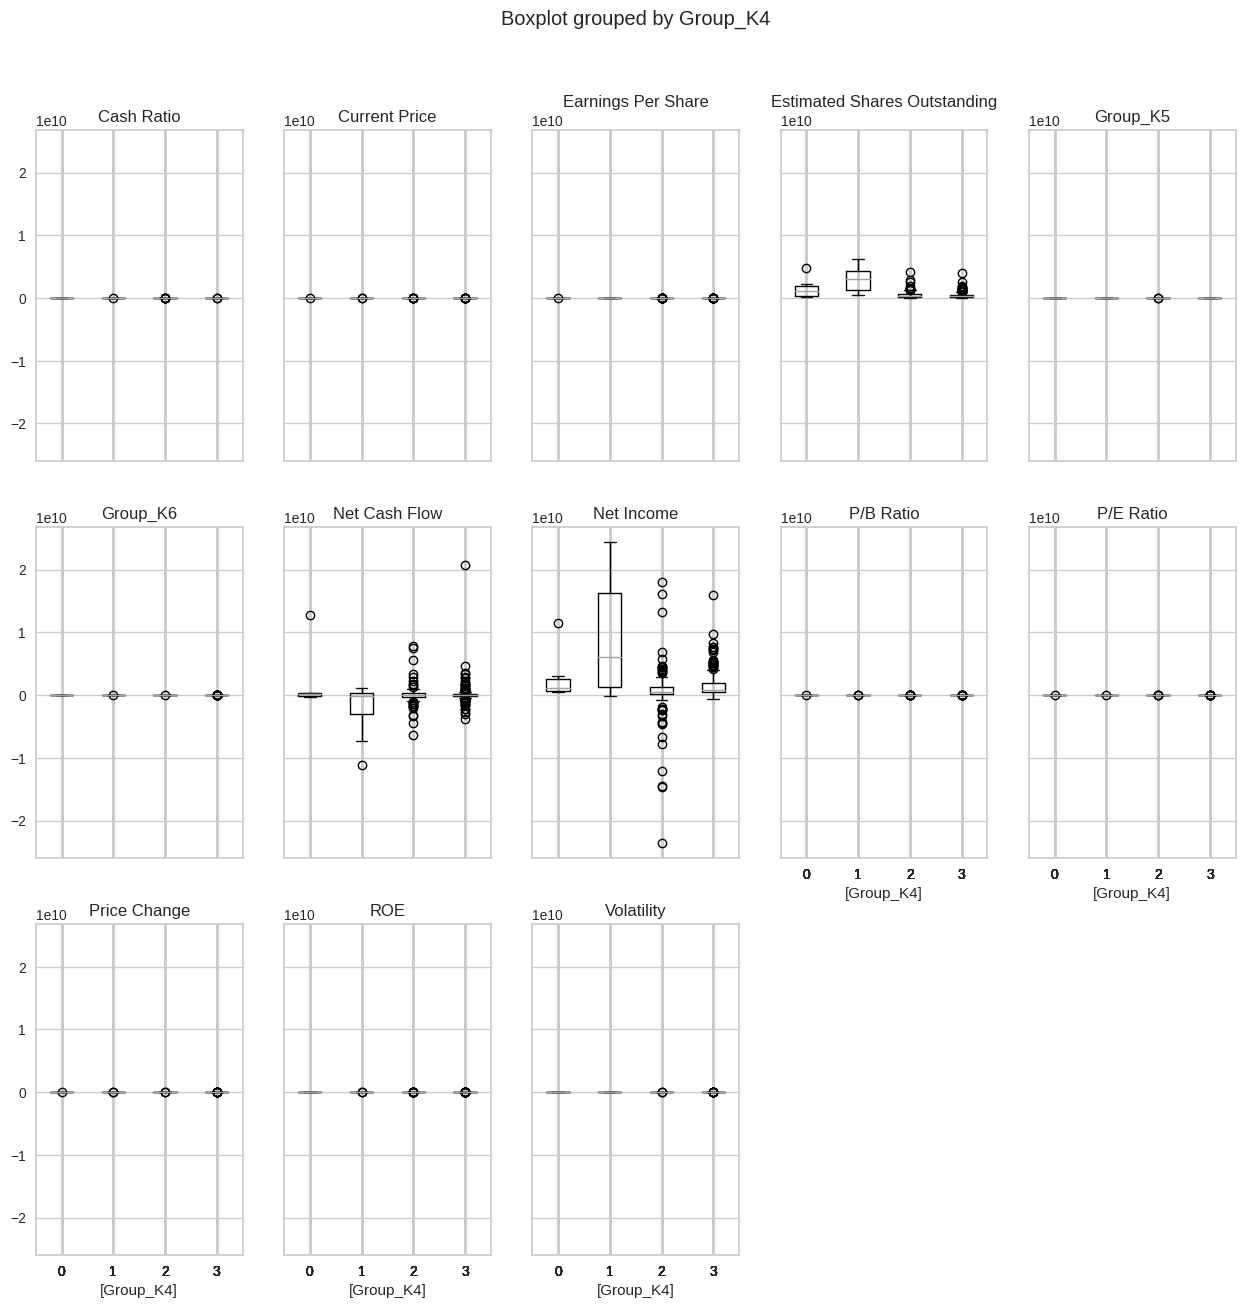

In [44]:
df.boxplot(by='Group_K4', layout=(3,5), figsize=(15,15));

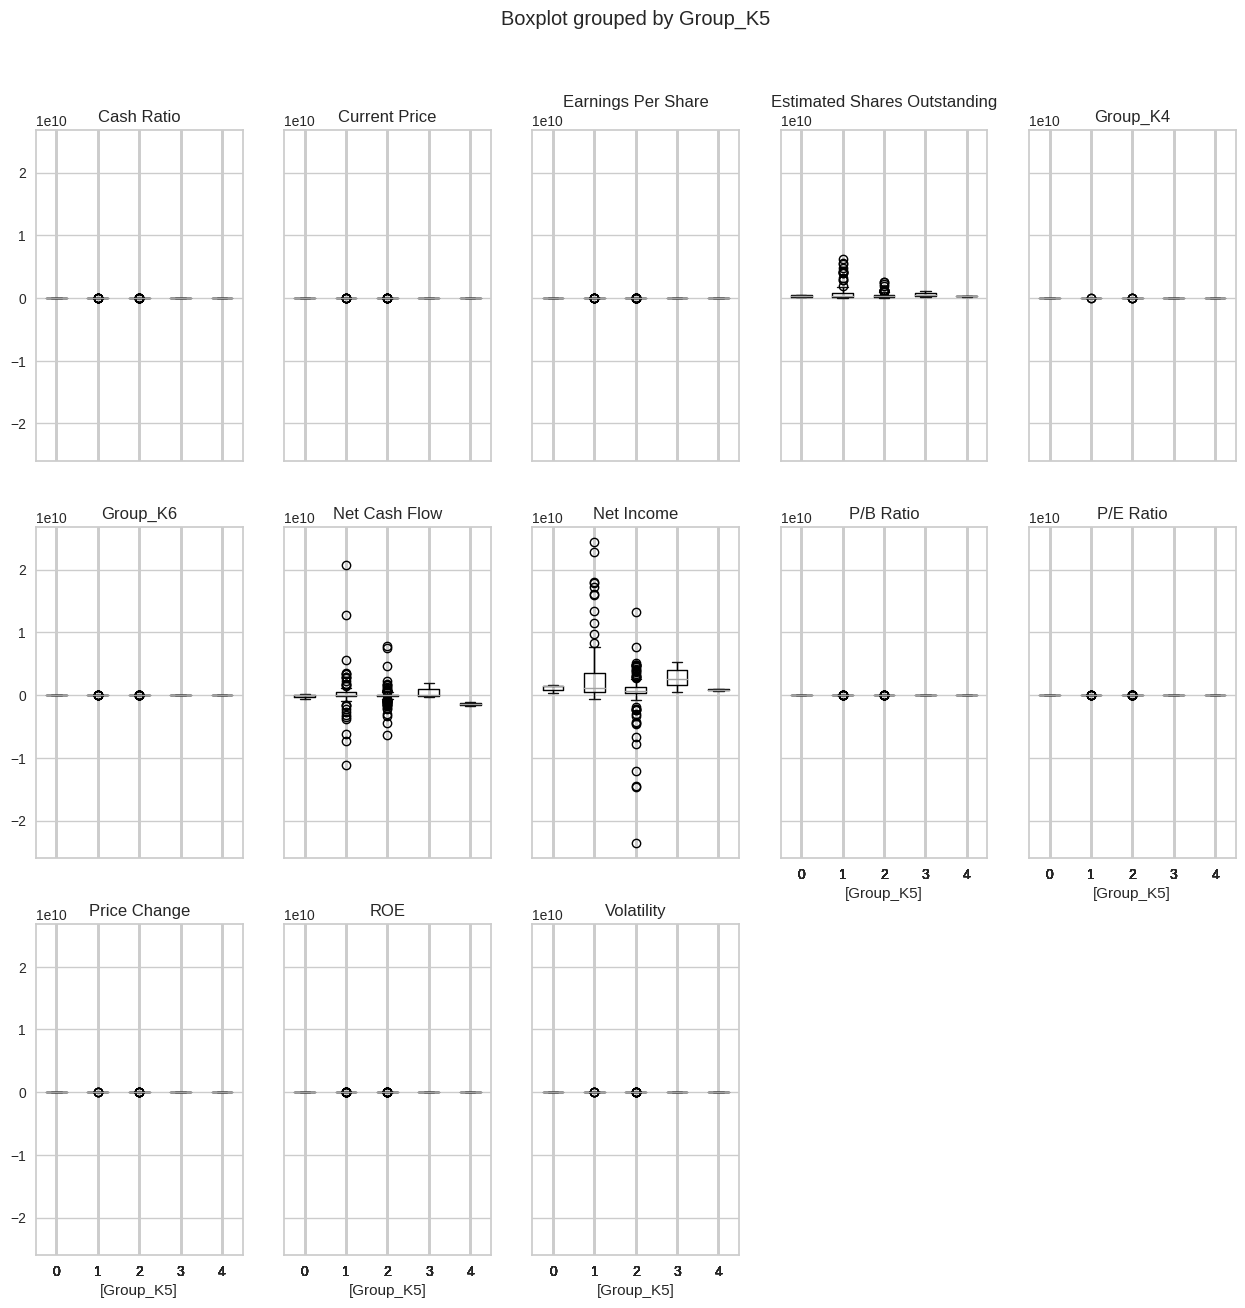

In [45]:
df.boxplot(by='Group_K5', layout=(3,5), figsize=(15,15));

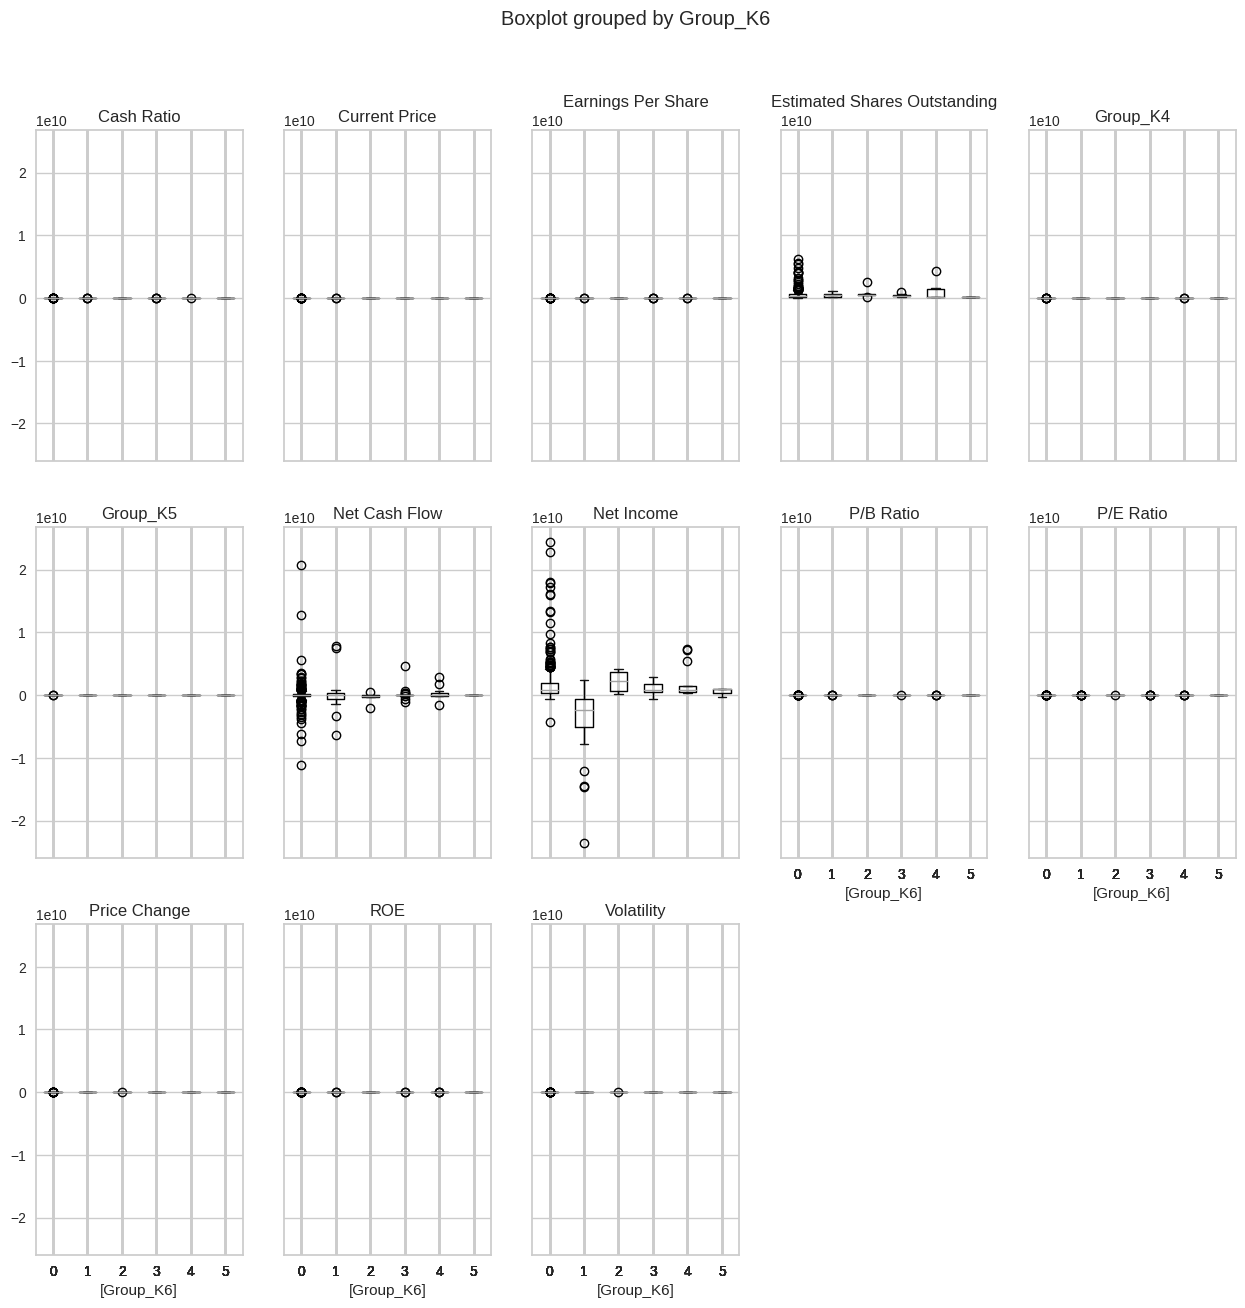

In [46]:
df.boxplot(by='Group_K6', layout=(3,5), figsize=(15,15));

Net Cash Flow, Net Income, and to a lesser extent, Estimated Shares Outstanding are the only features that have differences between the groups.

will use k=5 for the final model

In [47]:
# will drop columns for k=4 and k=6
df=df.drop(['Group_K4', 'Group_K6'], axis=1)

In [48]:
# how many stocks in each group
df['Group_K5'].value_counts()

2    192
1    140
3      3
0      3
4      2
Name: Group_K5, dtype: int64

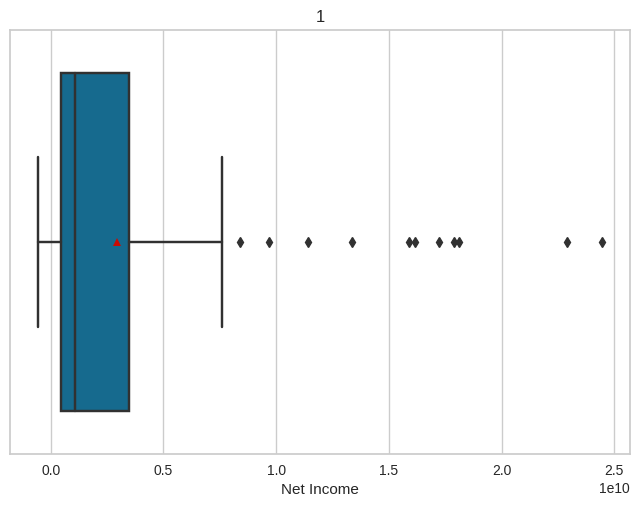

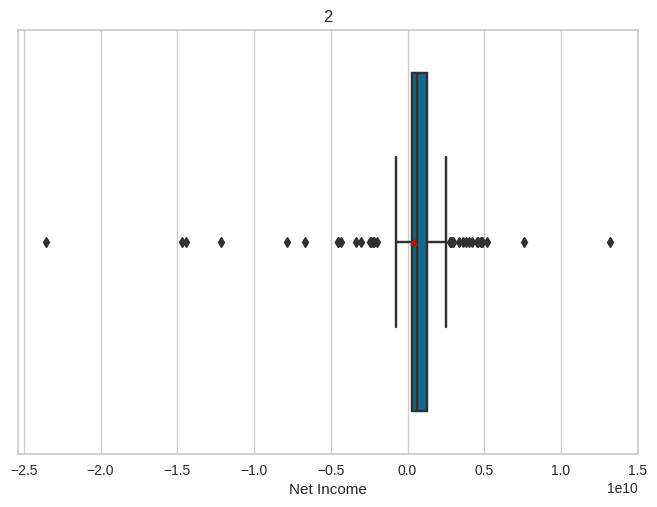

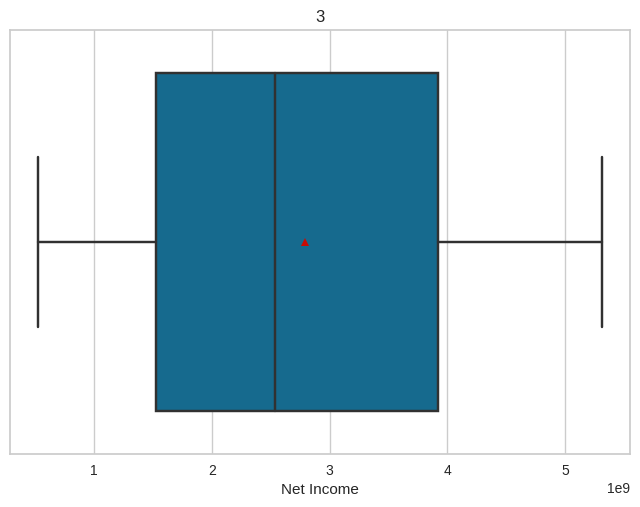

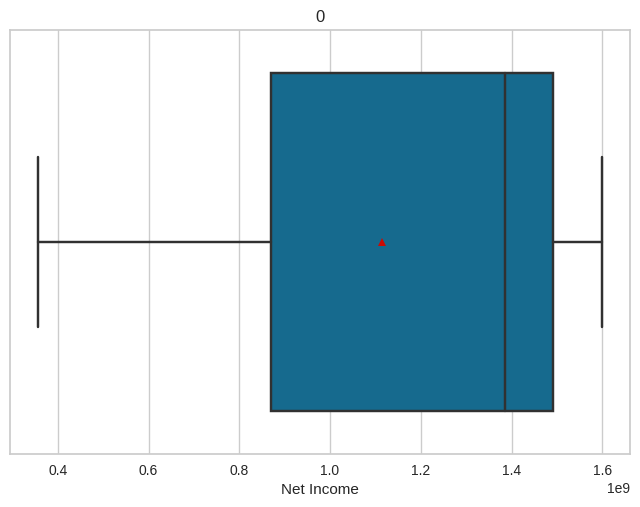

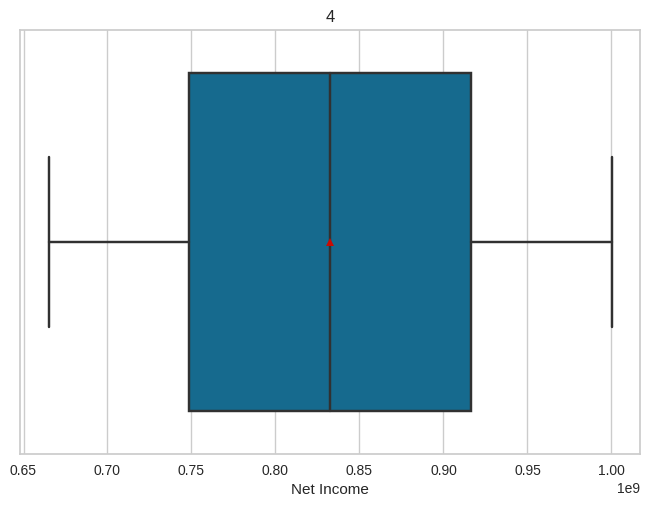

In [49]:
for i in df['Group_K5'].unique():
  sns.boxplot(data=df[df['Group_K5']==i], x='Net Income', showmeans=True);
  plt.title(i)
  plt.show()

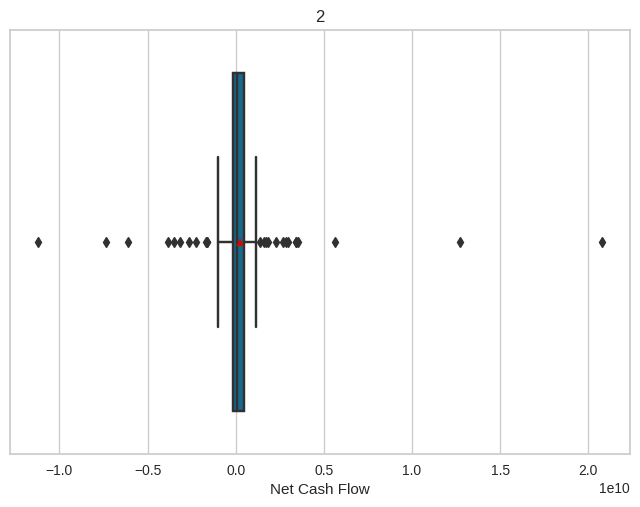

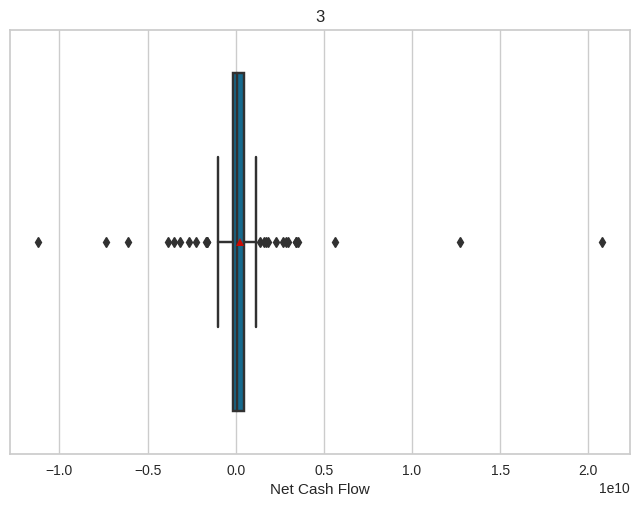

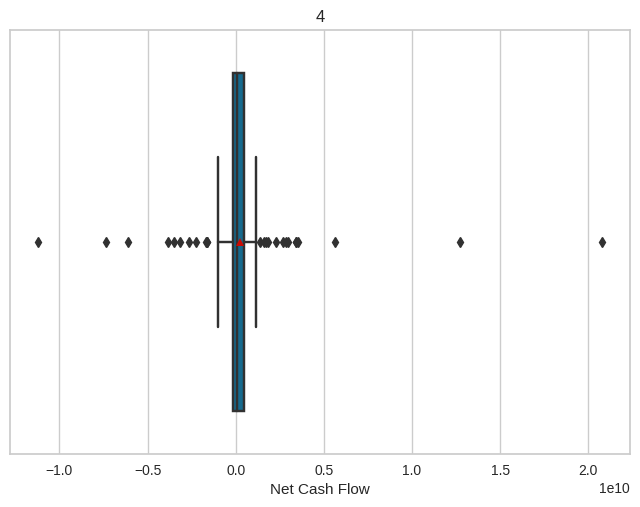

In [50]:
for i in df['Group_K5'].unique():
  sns.boxplot(data = df[df['Group_K5']==1], x = 'Net Cash Flow', showmeans=True)
  plt.title(i)
  plt.show()

## Hierarchical Clustering

In [51]:
df.drop('Group_K5', axis=1)

Ticker Symbol                 Security             GICS Sector  \
0             AAL  American Airlines Group             Industrials   
1            ABBV                   AbbVie             Health Care   
2             ABT      Abbott Laboratories             Health Care   
3            ADBE        Adobe Systems Inc  Information Technology   
4             ADI     Analog Devices, Inc.  Information Technology   
..            ...                      ...                     ...   
335          YHOO               Yahoo Inc.  Information Technology   
336           YUM          Yum! Brands Inc  Consumer Discretionary   
337           ZBH   Zimmer Biomet Holdings             Health Care   
338          ZION            Zions Bancorp              Financials   
339           ZTS                   Zoetis             Health Care   

                GICS Sub Industry  Current Price  Price Change  Volatility  \
0                        Airlines          42.35         10.00        1.69   
1                 Pharmaceuticals          59.24          8.34        2.20   
2           Health Care Equipment          44.91         11.30        1.27   
3            Application Software          93.94         13.98        1.36   
4                  Semiconductors          55.32         -1.83        1.70   
..                            ...            ...           ...         ...   
335  Internet Software & Services          33.26         14.89        1.85   
336                   Restaurants          52.52         -8.70        1.48   
337         Health Care Equipment         102.59          9.35        1.40   
338                Regional Banks          27.30         -1.16        1.47   
339               Pharmaceuticals          47.92         16.68        1.61   

     ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0    135          51     -604000000  7610000000               11.39   
1    130          77       51000000  5144000000                3.15   
2     21          67      938000000  4423000000                2.94   
3      9         180     -240840000   629551000                1.26   
4     14         272      315120000   696878000                0.31   
..   ...         ...            ...         ...                 ...   
335   15         459    -1032187000 -4359082000               -4.64   
336  142          27      159000000  1293000000                2.97   
337    1         100      376000000   147000000                0.78   
338    4          99      -43623000   309471000                1.20   
339   32          65      272000000   339000000                0.68   

     Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                    668129938.50       3.72      -8.78  
1                   1633015873.00      18.81      -8.75  
2                   1504421769.00      15.28      -0.39  
3                    499643650.80      74.56       4.20  
4                   2247993548.00     178.45       1.06  
..                            ...        ...        ...  
335                  939457327.60      28.98       6.26  
336                  435353535.40      17.68      -3.84  
337                  188461538.50     131.53     -23.88  
338                  257892500.00      22.75      -0.06  
339                  498529411.80      70.47       1.72  

[340 rows x 15 columns]

In [52]:
model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
model.fit(df1_scaled)

AgglomerativeClustering(linkage='average', metric='euclidean', n_clusters=3)

In [53]:
df['Labels']=model.labels_
df.head(10)

Ticker Symbol                   Security             GICS Sector  \
0           AAL    American Airlines Group             Industrials   
1          ABBV                     AbbVie             Health Care   
2           ABT        Abbott Laboratories             Health Care   
3          ADBE          Adobe Systems Inc  Information Technology   
4           ADI       Analog Devices, Inc.  Information Technology   
5           ADM  Archer-Daniels-Midland Co        Consumer Staples   
6           ADS      Alliance Data Systems  Information Technology   
7           AEE                Ameren Corp               Utilities   
8           AEP    American Electric Power               Utilities   
9           AFL                  AFLAC Inc              Financials   

                       GICS Sub Industry  Current Price  Price Change  \
0                               Airlines          42.35         10.00   
1                        Pharmaceuticals          59.24          8.34   
2                  Health Care Equipment          44.91         11.30   
3                   Application Software          93.94         13.98   
4                         Semiconductors          55.32         -1.83   
5                  Agricultural Products          36.68        -12.02   
6  Data Processing & Outsourced Services         276.57          6.19   
7                         MultiUtilities          43.23          2.17   
8                     Electric Utilities          58.27          2.37   
9                Life & Health Insurance          59.90          3.03   

   Volatility  ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0        1.69  135          51     -604000000  7610000000               11.39   
1        2.20  130          77       51000000  5144000000                3.15   
2        1.27   21          67      938000000  4423000000                2.94   
3        1.36    9         180     -240840000   629551000                1.26   
4        1.70   14         272      315120000   696878000                0.31   
5        1.52   10          49     -189000000  1849000000                2.99   
6        1.12   30          25       90885000   596541000                8.91   
7        1.12    9          14      287000000   636000000                2.60   
8        1.07   11           9       13900000  2052300000                3.13   
9        1.05   14          99     -308000000  2533000000                5.88   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K5  Labels  
0                  668129938.50       3.72      -8.78         1       0  
1                 1633015873.00      18.81      -8.75         1       0  
2                 1504421769.00      15.28      -0.39         1       0  
3                  499643650.80      74.56       4.20         2       0  
4                 2247993548.00     178.45       1.06         2       0  
5                  618394648.80      12.27       7.50         2       0  
6                   66951851.85      31.04     129.06         2       0  
7                  244615384.60      16.63      -0.72         2       0  
8                  421897810.20      18.46      -3.02         2       0  
9                  430782312.90      10.19      -1.88         3       0

In [54]:
stock_cluster = df.groupby(['Labels'])
stock_cluster.mean(numeric_only=True)

Current Price  Price Change  Volatility    ROE  Cash Ratio  \
Labels                                                               
0               81.16          4.12        1.52  39.27       70.24   
1               54.36         24.71        1.46  34.00       61.00   
2                6.77        -31.69        3.80 155.00        5.00   

        Net Cash Flow      Net Income  Earnings Per Share  \
Labels                                                      
0         55765653.85   1529034807.69                2.80   
1        274000000.00   3433000000.00                9.71   
2       -240000000.00 -12156000000.00              -11.31   

        Estimated Shares Outstanding  P/E Ratio  P/B Ratio  Group_K5  
Labels                                                                
0                       576216806.91      32.72      -1.73      1.59  
1                       353553038.10       5.60      -2.25      1.00  
2                      1074801061.00      22.81       2.94      2.00

In [55]:
# Cophenet index is a measure of the correlationbetween the distance of points in feature space and distance on the Dendrogram
# The closer it is to 1, the better the clustering
Z = linkage(df1_scaled)
c, coph_dists = cophenet(Z, pdist(df1_scaled))
c

0.9428056913166736

### Checking Cophenetic Correlation

In [56]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(df1_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(df1_scaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9428056913166736.
Cophenetic correlation for Euclidean distance and complete linkage is 0.9049140335022633.
Cophenetic correlation for Euclidean distance and average linkage is 0.9568036849241168.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9393246862514139.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9261054128666718.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8443609321608778.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9347573498824756.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9347972684386713.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9248253723524654.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.920820817588118.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9353132700270396.
Cophenetic cor

Euclidean distance seems to provide the best cophenetic scores

**Let's explore different linkage methods with Euclidean distance only.**

In [57]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(df1_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(df1_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9428056913166736.
Cophenetic correlation for complete linkage is 0.9049140335022633.
Cophenetic correlation for average linkage is 0.9568036849241168.
Cophenetic correlation for centroid linkage is 0.9526171575733697.
Cophenetic correlation for ward linkage is 0.2007680733245181.
Cophenetic correlation for weighted linkage is 0.9393246862514139.


Average method provides the best cophenetic score.  Will now take a look at the dendrogrmas for euclidean

### Checking Dendrograms

**Let's see the dendrograms for the different linkage methods.**

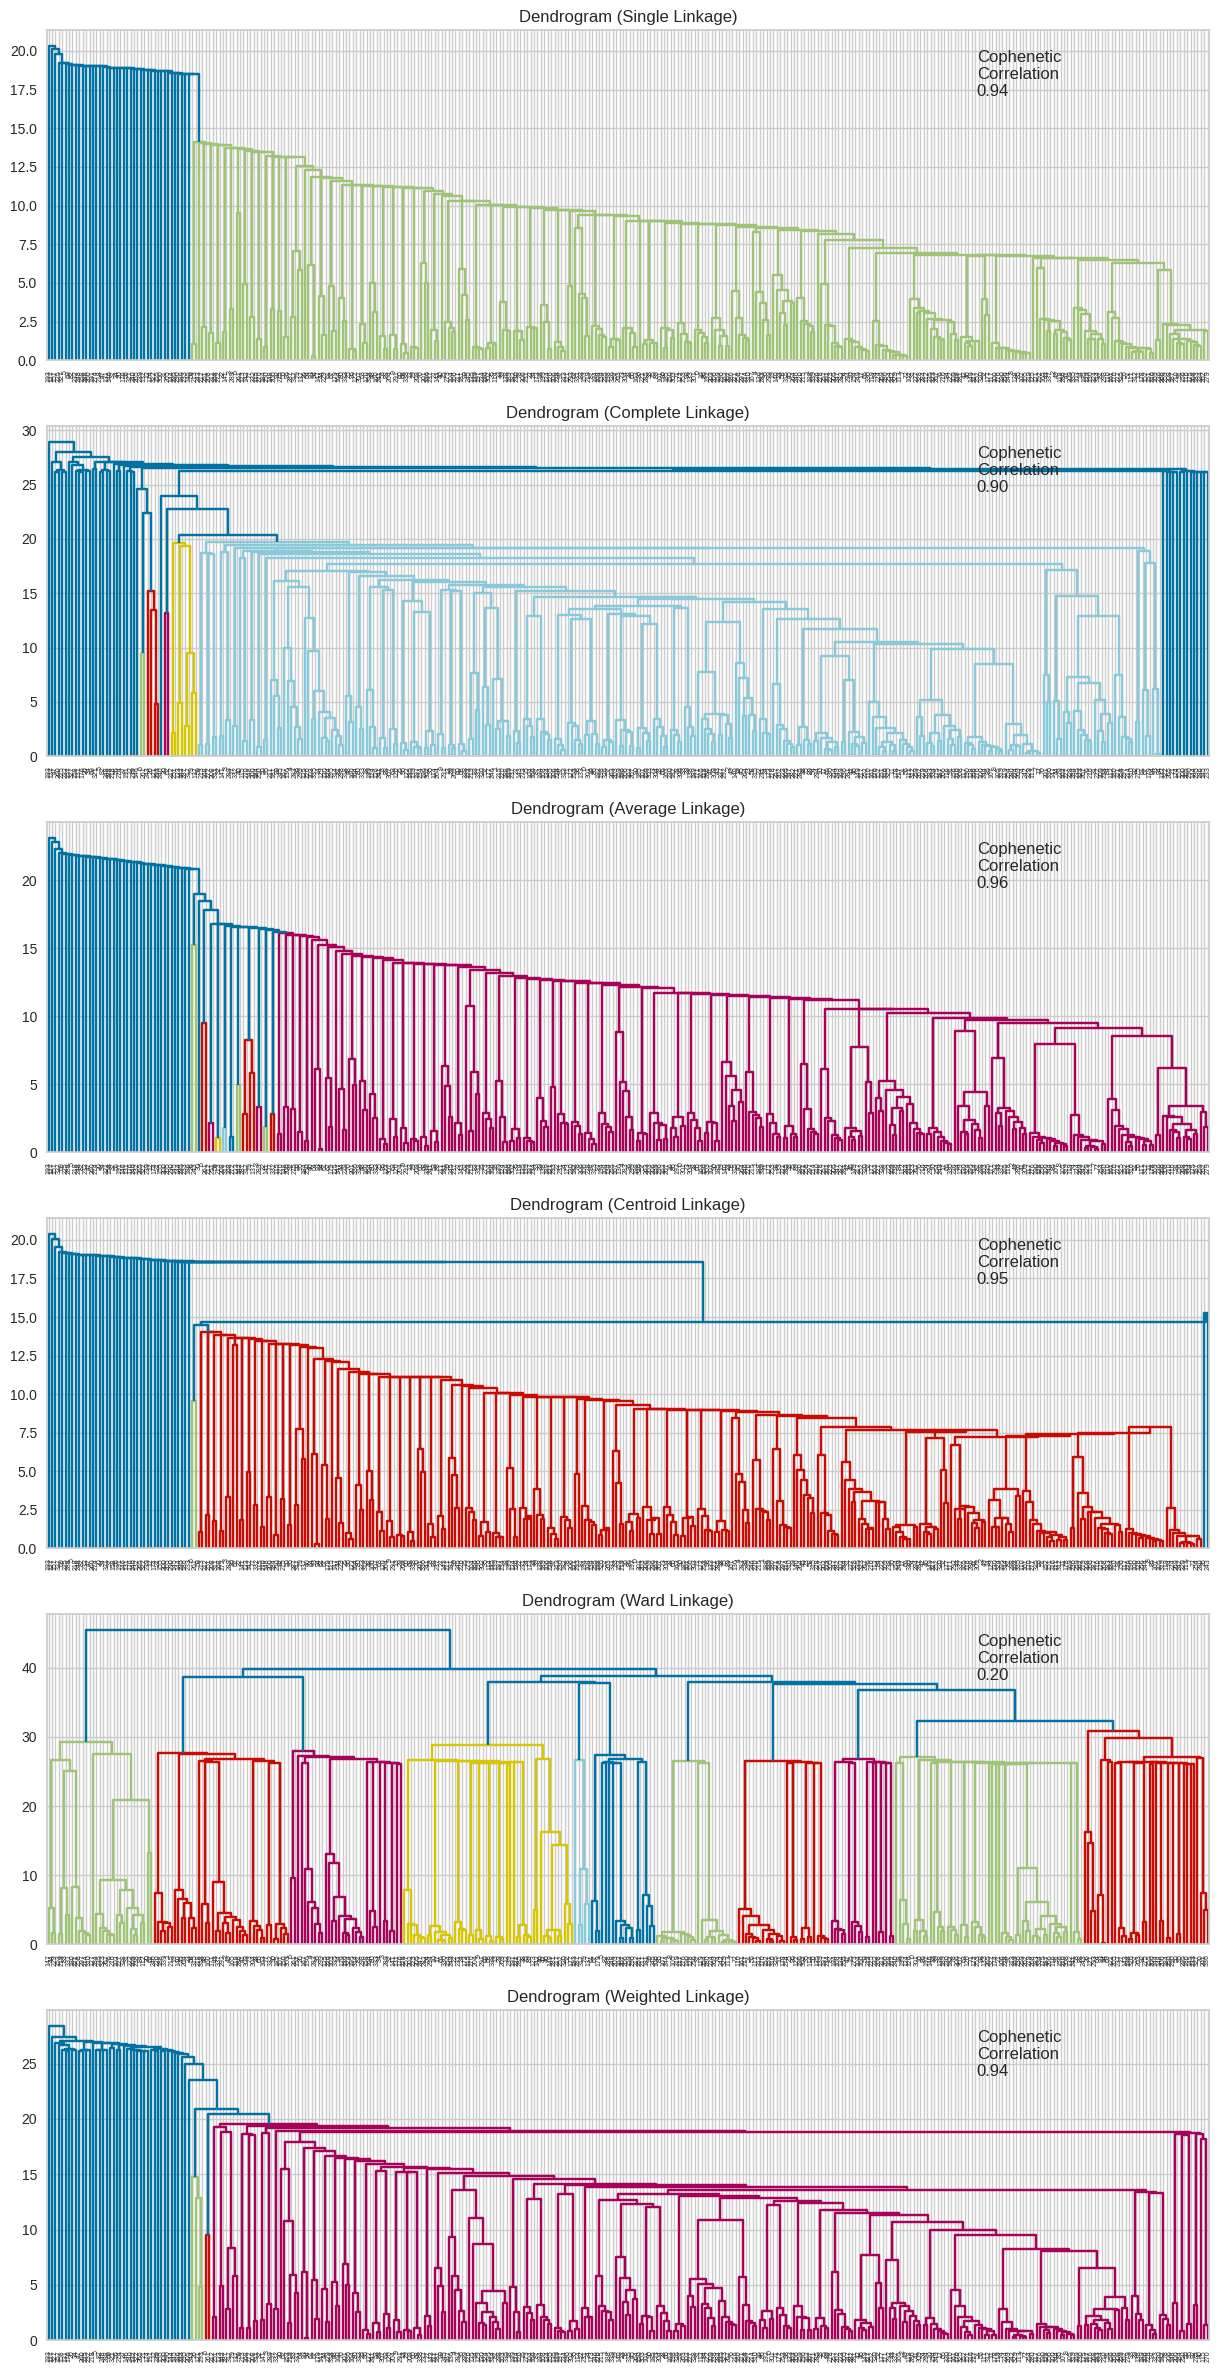

In [58]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(df1_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(df1_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

While 'average' has a higher cophenetic score,
'complete' seems to have better cluster separations after viewing the dendrograms with the appropriate amount of clusters looking like 5

In [59]:
HC_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='complete')
HC_model.fit(df1_scaled)

df1_scaled['Labels'] = HC_model.labels_
df['Labels'] = HC_model.labels_
df.sample(15)

Ticker Symbol                     Security             GICS Sector  \
156           HON         Honeywell Int'l Inc.             Industrials   
83            CVX                Chevron Corp.                  Energy   
128            FE             FirstEnergy Corp               Utilities   
212            MO             Altria Group Inc        Consumer Staples   
170           IRM   Iron Mountain Incorporated             Real Estate   
278          SPGI             S&P Global, Inc.              Financials   
263           RCL  Royal Caribbean Cruises Ltd  Consumer Discretionary   
217           MTB               M&T Bank Corp.              Financials   
120          EXPD             Expeditors Int'l             Industrials   
24            AMP         Ameriprise Financial              Financials   
45           BIIB             BIOGEN IDEC Inc.             Health Care   
318           WAT           Waters Corporation             Health Care   
34           ATVI          Activision Blizzard  Information Technology   
259           PWR         Quanta Services Inc.             Industrials   
213           MOS           The Mosaic Company               Materials   

                        GICS Sub Industry  Current Price  Price Change  \
156              Industrial Conglomerates         103.57          9.32   
83                   Integrated Oil & Gas          89.96         12.84   
128                    Electric Utilities          31.73          1.18   
212                               Tobacco          58.21          6.89   
170                                 REITs          27.01        -13.07   
278        Diversified Financial Services          98.58         14.04   
263        Hotels, Resorts & Cruise Lines         101.21         13.43   
217                                 Banks         121.18         -0.36   
120               Air Freight & Logistics          45.10         -4.45   
24       Asset Management & Custody Banks         106.42         -2.42   
45                          Biotechnology         306.35          4.92   
318              Health Care Distributors         134.58         13.93   
34            Home Entertainment Software          38.71         23.32   
259              Industrial Conglomerates          20.25        -16.63   
213  Fertilizers & Agricultural Chemicals          27.59        -11.23   

     Volatility  ROE  Cash Ratio  Net Cash Flow  Net Income  \
156        1.10   26          41    -1504000000  4768000000   
83         1.75    3          43    -1763000000  4587000000   
128        1.24    5           2       46000000   578000000   
212        0.96  182          33     -952000000  5241000000   
170        1.30   24          15        2448000   123241000   
278        1.08  596          51    -1016000000  1156000000   
263        1.56    8           9      -67676000   665783000   
217        1.38    7          99       -5317000  1079667000   
120        1.06   27          94     -119311000   457223000   
24         1.22   22          67     -281000000  1562000000   
45         1.83   38         133      148900000  3547000000   
318        1.04   23         425       65488000   469053000   
34         1.89   11          70    -3025000000   892000000   
259        2.95   10          11      -61744000   321824000   
213        2.83   10          62    -1098300000  1000400000   

     Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  P/B Ratio  \
156                6.11                  780360065.50      16.95      -3.71   
83                 2.46                 1864634146.00      36.57       4.76   
128                1.37                  421897810.20      23.16      -6.07   
212                2.67                 1962921348.00      21.80      -6.63   
170                0.58                  212484482.80      46.57      -2.76   
278                4.26                  271361502.30      23.14      -4.18   
263                3.03                  219730363.00      33.40     -15

###K Means clustering analysis

In [82]:
km_cluster_profile = df.groupby('Group_K5').mean()


<ipython-input-82-5885debaa395>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  km_cluster_profile = df.groupby('Group_K5').mean()


In [83]:
km_cluster_profile['count_in_each_segment'] = (
    df.groupby('Group_K5')['Security'].count().values
)

In [85]:
km_cluster_profile.style.highlight_max(color='lightgreen', axis=0)

###Hierarchical clustering analysis

In [86]:
hc_cluster_profile = df.groupby('Labels').mean()


<ipython-input-86-489a7a1cfc10>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hc_cluster_profile = df.groupby('Labels').mean()


In [87]:
hc_cluster_profile['count_in_each_segment'] = (
    df.groupby('Labels')['Security'].count().values
)

In [88]:
hc_cluster_profile.style.highlight_max(color='lightgreen', axis=0)

## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [60]:
df['Labels'].value_counts()

2    325
1      7
0      5
4      2
3      1
Name: Labels, dtype: int64

In [61]:
df['Group_K5'].value_counts()

2    192
1    140
3      3
0      3
4      2
Name: Group_K5, dtype: int64

Both KMeans and Hierarchical clustering have simlar numbers per group.

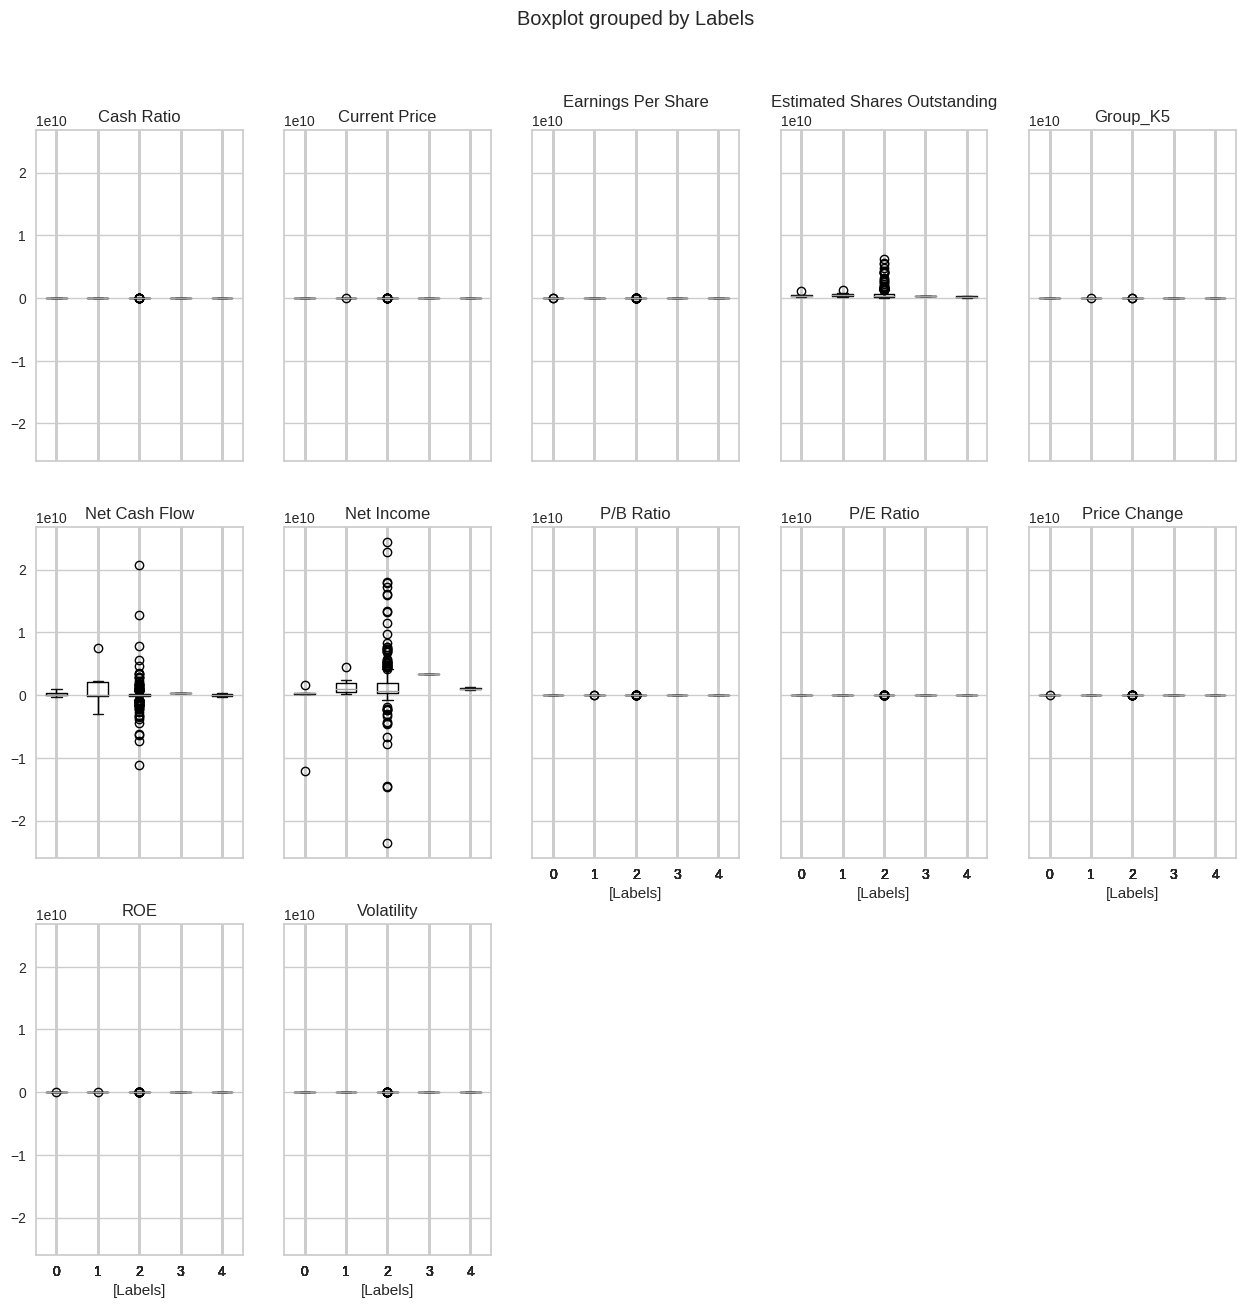

In [62]:
df.boxplot(by='Labels', layout=(3,5), figsize=(15,15));

In [63]:
df.boxplot(by='Group_K5', layout=(3,5), figsize=(15,15));

Both KMeans and Hierarchical clustering had similar run times and very identical clustering.

In both cases, the only features with much disparity by cluster are 'Net Income', 'Net Cash Flow', and, to a lesser extent, 'Estimated Shares Outstanding'.

<Axes: xlabel='Group_K5', ylabel='count'>

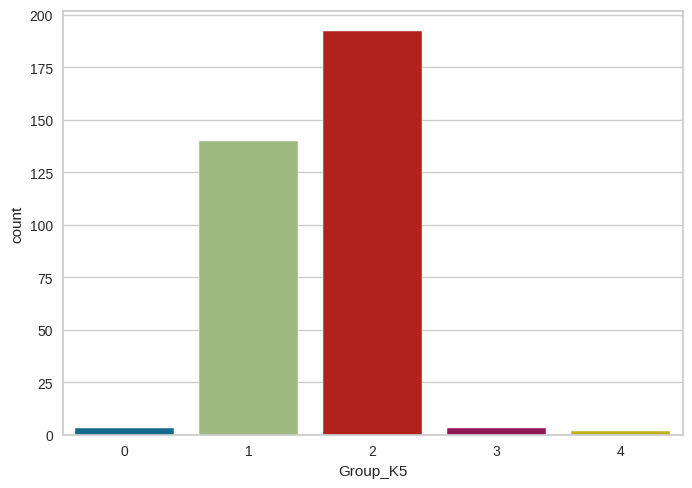

In [64]:
sns.countplot(data=df, x='Group_K5')

In [65]:
sns.countplot(data=df, x='Labels')

<Axes: xlabel='Labels', ylabel='count'>

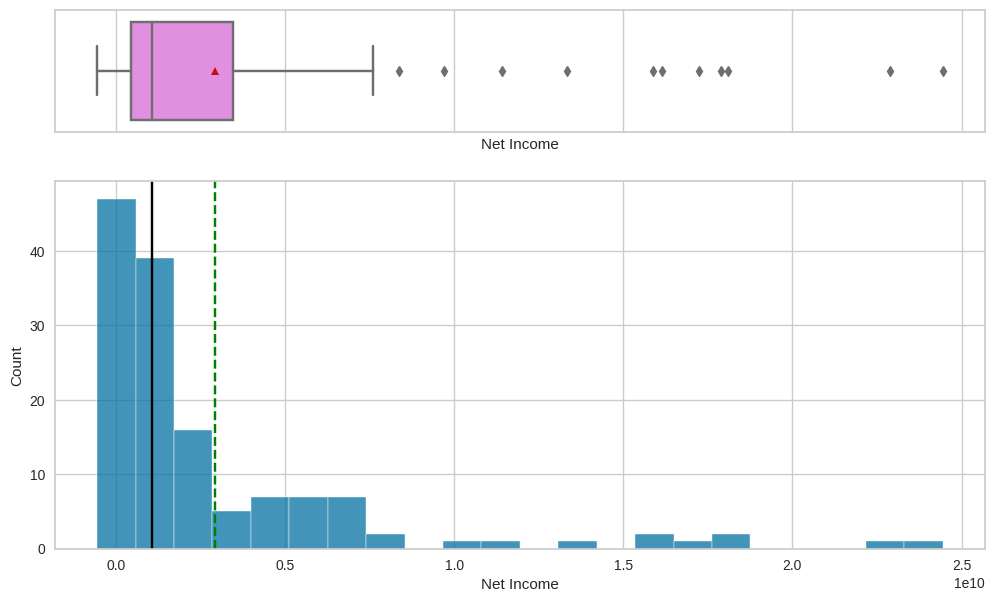

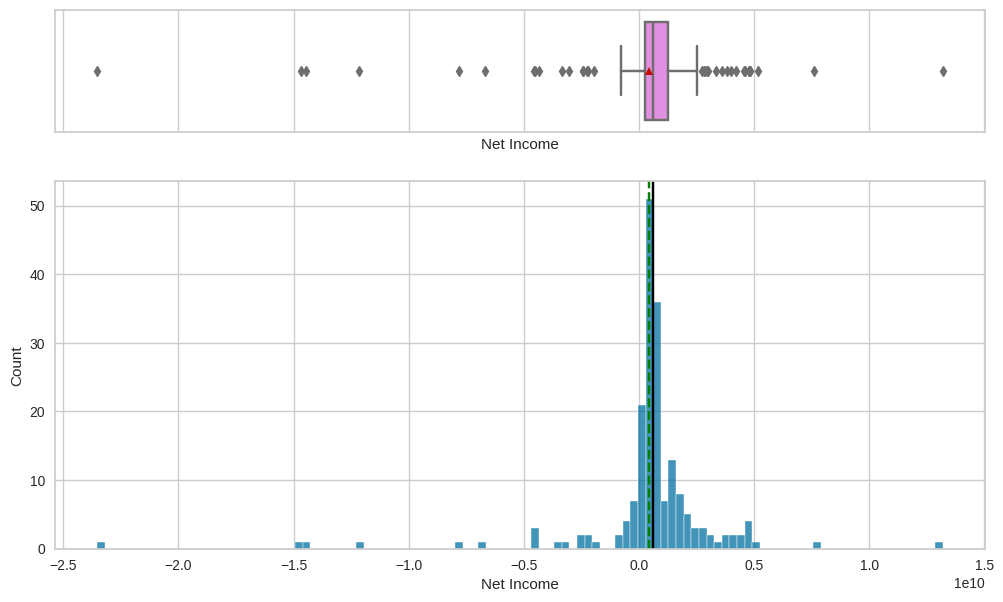

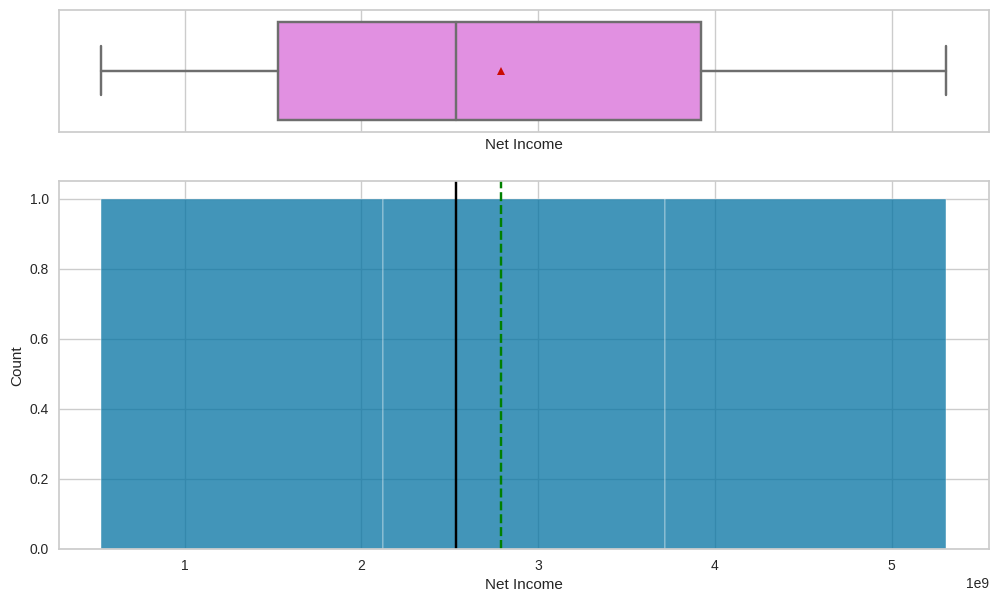

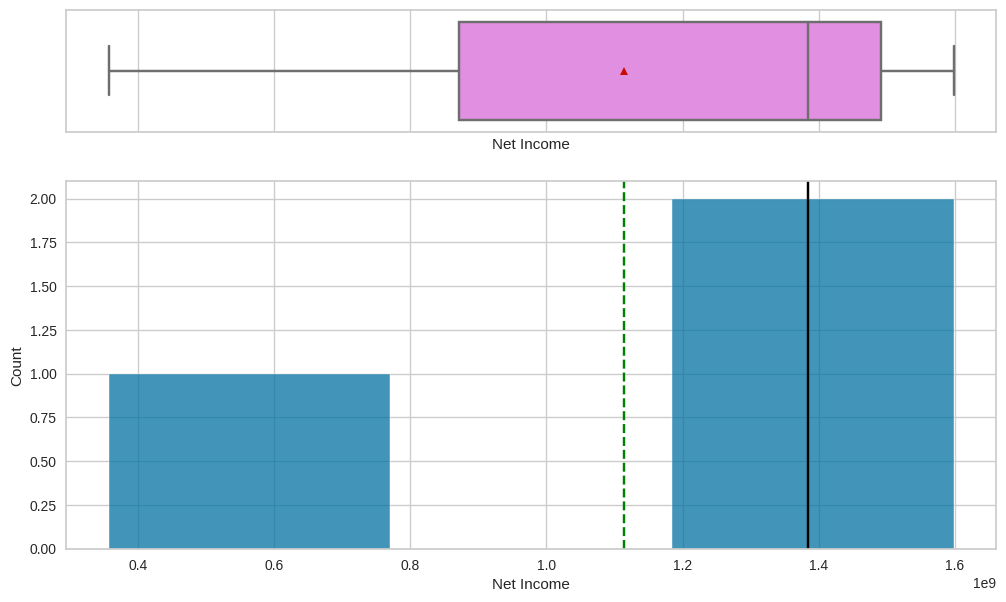

In [66]:
for i in df['Group_K5'].unique():
  histogram_boxplot(df[df['Group_K5']==i], feature='Net Income');
  plt.show()

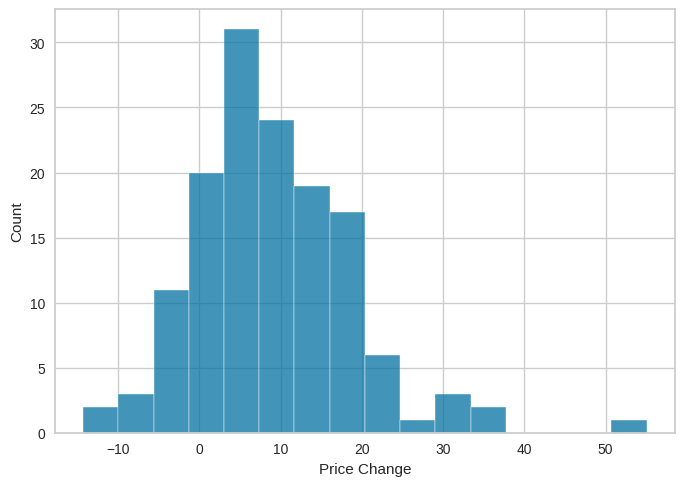

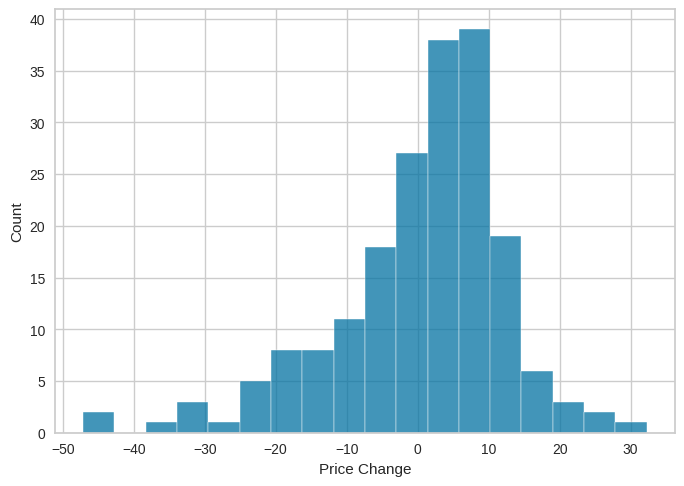

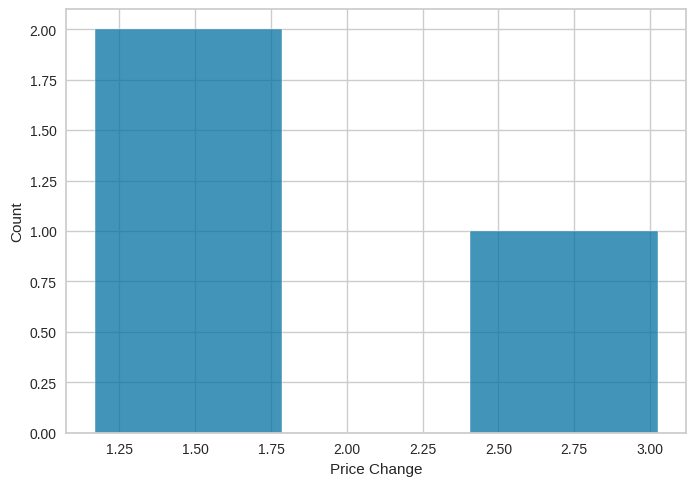

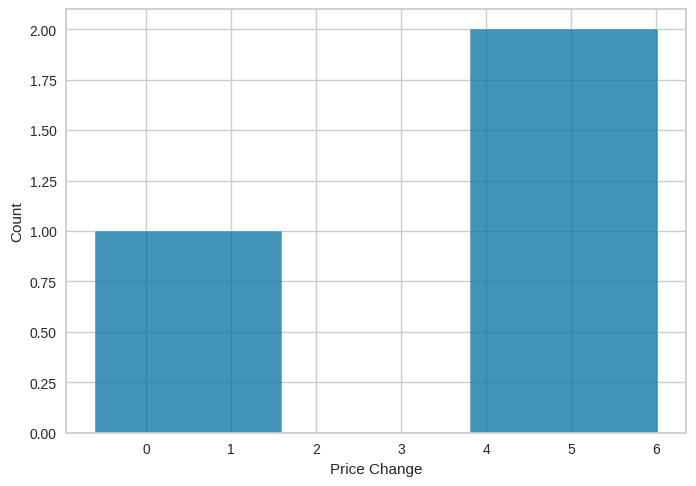

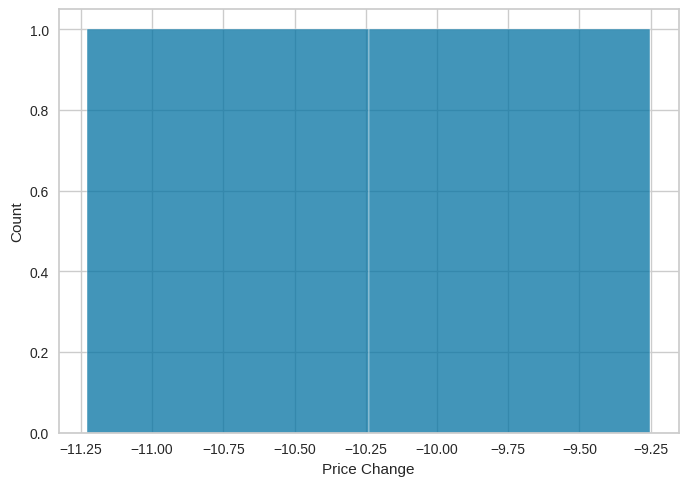

In [67]:
for i in df['Group_K5'].unique():
  sns.histplot(data=df[df['Group_K5']==i], x='Price Change');
  plt.show()

## Actionable Insights and Recommendations

- 

Net Income, Net Cash Flow, and Estimated Shares Outstanding are the features with the most importance to clustering.

These are the features that should be considered when grouping stocks.

## MLS Notes and updates 

import warning
warnings.filterwarnings('ignore')
- During build and first run, do NOT ignore warnings, can correct deprecated functions, etc.  For final run/presentation, run to ignore warnings for a clean final product.

For clustering, could/should remove all the categorical features, including GICS Sector and GISC Sub Industry.  Just look at the numerical data.

KMeans- most data was in one cluster,regardless of n_clusters
- drop some columns?
  - The best columns to keep have Larger Ranges and Normally Distributed

- Should def display silhouette score and SihouetteVisualizer to view the clusters

- use EDA and .describe() to analyize which columns to use/keep

- Silhouette Visualizer  values to the left of '0' could be in wrong cluster... read up


- use cluster_profile
  - into df and highlight  look up the class notebooks with cluster df with green highlights

- df1.groupby('KM_segments', GICS Sector])['Security].count()
  - will show the count by cluster from each GICS sector


Get the PCA section from the MLS solution notebook


#General DS career advice
upskills required

SQL
Visualization with Power BI and Tableau

Statistics
**ANOVA** brush up on

CNN-Computer Vision-NLP


Data Scientists are Masters of All
- embrace/leverage Top-Down overall view of all departments/sectors of and organization